In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp

import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit
import corner

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

In [3]:
runOnlyGP=False
runOnlyFF=False

### load inputs

In [4]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = list(np.load("newoutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

#10000 toys - created from smoothed data with Poisson noise
toyList = np.load("newoutputs/toyList.npy")
#hyperparameters (kernel and mean) from GP fit to ATLAS data.
fixedHyperparams = np.load("newoutputs/fixedHyperparams.npy")

#injected signal sets
sigToys = np.load("newoutputs/signalToys.npy")
#sigToysO = np.load("newoutputs/signalToysO.npy")
standardParamSets = [(2000,2000,250), (700, 2500, 250), (250, 3000, 250), (125, 3500, 250), (70, 4000, 250), 
             (40, 4500, 250), (25, 5000, 250), (15,5500, 250), (10, 6000,250)]


### Gaussian signal function

In [5]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

### 3 and 5 parameters fit function

In [6]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  
def model_5param(t, params, xErr=xerr): 
    p0, p1, p2, p3, p4 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2+p3*np.log(t/sqrts)+p4*np.log(t/sqrts)**2))*(xErr)

### Calculate z values and chi squared 

In [7]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### mean and variance of non-central chi2

In [8]:
def chi2_mean_variance(DOF, nc):
    mean = nc
    variance = np.sqrt(nc)
    return mean, variance

### Poisson log likelihood

In [9]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.) 
        return lnpoisson

### remove zero count bins to use for GP fits

In [10]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### fit for noncentrality parameter of non central chi-squared

In [11]:
def ncchi(x, nc):
    return ss.ncx2.pdf(x, 1., nc) 

### pretty plots showing background only fit and background+signal fit

In [18]:
def makePrettyPlots_signal(xs, ys, bkgs, bkgsigs, title, mass, col = 'g', ymax = 2e5):
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    f.suptitle(title, fontsize=40)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="ATLAS data+Injected signal")
    bkg1Plot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="Background only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='r', linewidth=3.0, label="Signal-plus-background")
    ax1.legend(prop={'size':20})
    ax1.set_ylabel('Events per bin', fontsize=40)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=30)
    ax1.axvline(mass, color='black', lw=1, linestyle="--")
    #ax1.arrow(mass, 1.5e2, 0, 3e2, lw=5, head_width=50, head_length=125)
    
    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    #ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_ylabel('Sig.', fontsize=40, labelpad=20)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=30)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.axvline(mass, color='black', lw=1, linestyle="--")
    #ax2.arrow(mass, -3, 0, 1.7, lw=5,head_width=50, head_length=0.5)

    zvals_2, chi2_2 = calcSignificance(ys, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlowO,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'red'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=40)
    #ax3.set_ylabel('Significance', fontsize=20)
    ax3.set_ylabel('Sig.', fontsize=40, labelpad=20)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=30)
    ax3.tick_params(axis='x', labelsize=30)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.axvline(mass, color='black', lw=1, linestyle="--")
    #ax3.arrow(mass, -3, 0, 1.7, lw=5,head_width=50, head_length=0.5)
    

    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()


### plot distribution of log likelihood from fits to toys

In [13]:
def makePrettyPlots_LLH(GP_LLH, FF_LLH, title, drawchi2=False, xname=r'$\chi^{2}$', label1 = "Gaussian Process", label2 = "Fit Function"):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=30)

    lowx = min(min(GP_LLH), min(FF_LLH))
    highx = max(max(GP_LLH), max(FF_LLH))
    bins = np.linspace(lowx, highx, 200)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.
    
    hGP, _, _ = ax1.hist(GP_LLH, bins=bins, color="b")
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    if drawchi2:
        bf_params_1, bf_cov_1 = op.curve_fit(ncchi, bin_centers, hGP)
        print "nc ", bf_params_1
        nc_chi = sum(hGP)*dx*ss.ncx2.pdf(bin_centers, 1., bf_params_1[0]) #bf_params[1]*
        ax1.plot(bin_centers, nc_chi, c='r', linewidth=2)
    
    
    hFF, _, _ =ax2.hist(FF_LLH, bins=bins, color='g')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    if drawchi2:
        bf_params_2, bf_cov_2 = op.curve_fit(ncchi, bin_centers, hFF)
        print "nc ", bf_params_2
        nc_chi = sum(hFF)*dx*ss.ncx2.pdf(bin_centers, 1., bf_params_2[0]) #bf_params[1]*
        ax2.plot(bin_centers, nc_chi, c='r', linewidth=3)

    plt.show()
    return bf_params_1, bf_params_2



### Poisson likelihood to use for Gaussian Process, for 3 parameter fit functions, 3 parameter fit function with signal strength parameter, 5 parameter fit function, and 5 parameter fit function with signal strength parameter. 

In [14]:
def logLike_gpLikeFF(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  

class logLike_3ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_3ff_sig:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, N):
        params = p0, p1, p2
        nSignal = N
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf
        
class logLike_5ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    
class logLike_5ff_sig:
    def __init__(self, x, y, xe, sigTemp):
        self.x = x
        self.y = y
        self.xe = xe
        self.sigTemp = sigTemp
    def __call__(self, p0, p1, p2, p3, p4, N):
        params = p0, p1, p2, p3, p4
        nSignal = N
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        sig=0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = self.sigTemp[ibin]*nSignal
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf

### Minuit minimization of 3 parameter fit function, 3 parameter plus signal strength, 5 parameter, and 5 parameter plus signal strength. minimize negative log likelihood, return minimum negative log likelihood and fit parameters corresponding to minimum.

In [15]:
def fit_3ff(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 10:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, 
                  limit_p0 = (0, 20.), limit_p1 = (-20., 20.), limit_p2 = (-20., 20.))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 9: 
            minLLH=np.inf
            best_fit_params=(0, 0, 0)
        numRetries+=1 

    if Print:
        print "min LL", minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

def fit_3ff_sig(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 15:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 0.1
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, N = init3,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_N = 1e-4,
                  limit_p0 = (0, 10.), limit_p1 = (-20., 20.), limit_p2 = (-20., 20.), limit_N = (0, 100))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 14: 
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

def fit_5ff(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, p3 = init3, p4 = init4,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p3 = 1e-2, error_p4 = 1e-2,
                  limit_p0 = (0, 10), limit_p1 = (-20, 20), limit_p2 = (-20, 20), 
                   limit_p3 = (-20, 20), limit_p4 = (-20, 20))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

def fit_5ff_sig(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        init5 = np.random.random() * 1
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, p3 = init3, p4 = init4, N = init5,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, error_p3 = 1e-2, error_p4 = 1e-2, error_N = 1e-4,
                  limit_p0 = (0, 10), limit_p1 = (-20, 20), limit_p2 = (-20, 20), 
                   limit_p3 = (-20, 20), limit_p4 = (-20, 20), limit_N = (0, 100))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0, 0)
        numRetries+=1

    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

### mean function for GP - 3 parameter fit function. negative log likelihood for Gaussian Process - from george. Minuit minimzation for GP negative log likelihood. Hyperparameters and mean function parameters are fixed, just fitting signal strength

In [16]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp_tempSig_fixedH:
    def __init__(self, x, y, xerr, sigTemp):
        self.x = x
        self.y = y
        self.xerr = xerr
        self.sigTemp = sigTemp
    def __call__(self, N):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr)-N*self.sigTemp)
        except:
            return np.inf        
        
def fit_gp_tempSig_fixedH_minuit(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   N = init0, error_N = 1e-4, limit_N = (0, 100)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params




### fit Gaussian Process background only and background plus signal on toys with injected signal. Check Poisson likelihood as well as george Gaussian likelihood. Hyperparameters and mean function parameters are fixed

(2000, 2000, 250)
chi2 bkg+signal mu=0 147.153366591
chi2 bkg+signal 65.2932821108


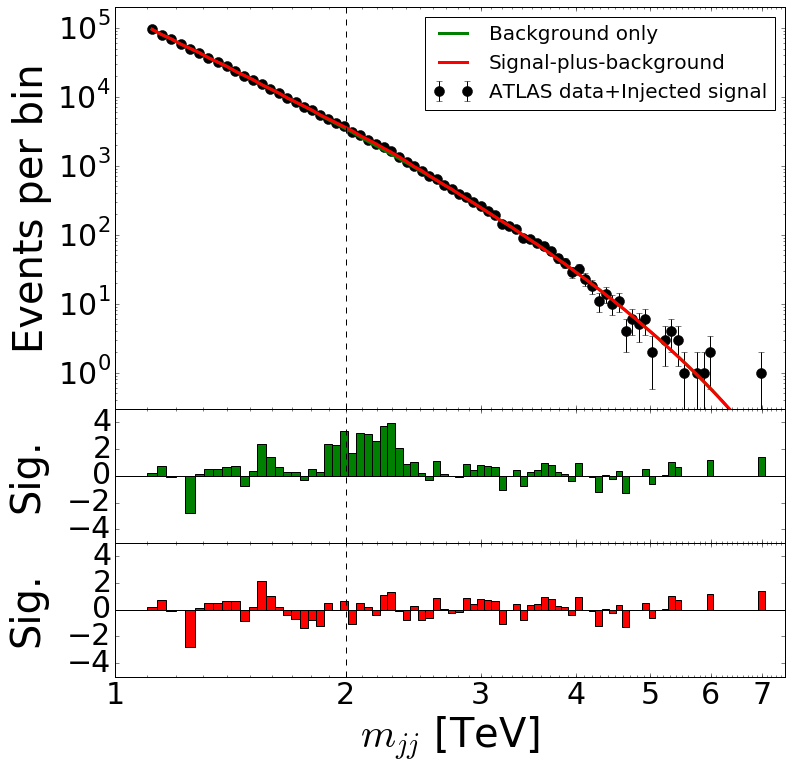

(700, 2500, 250)
chi2 bkg+signal mu=0 114.72711538
chi2 bkg+signal 65.3342875332


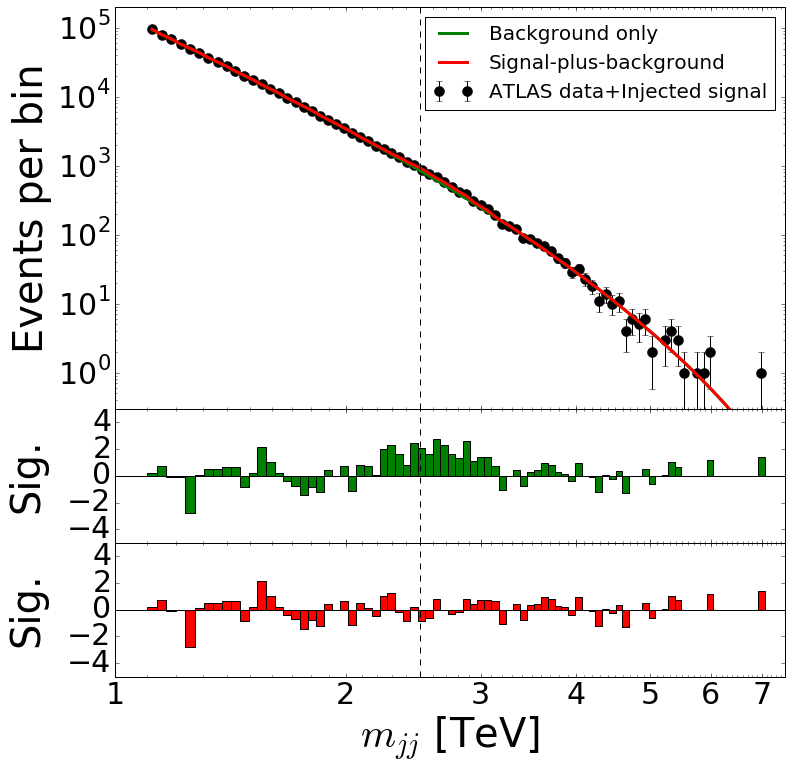

(250, 3000, 250)
chi2 bkg+signal mu=0 99.8920129295
chi2 bkg+signal 64.6093977732


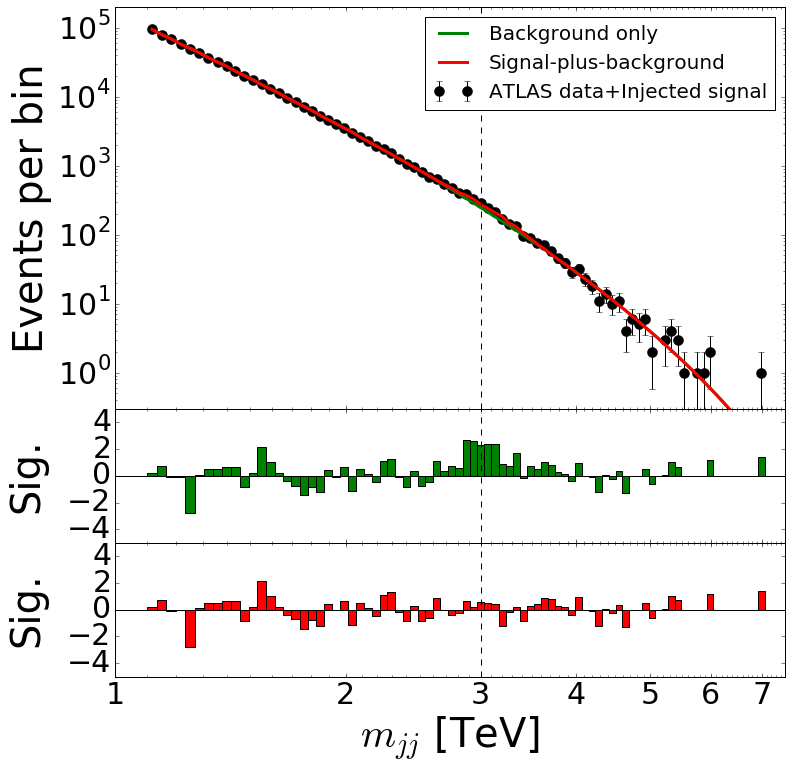

(125, 3500, 250)
chi2 bkg+signal mu=0 98.0146134385
chi2 bkg+signal 64.5290134254


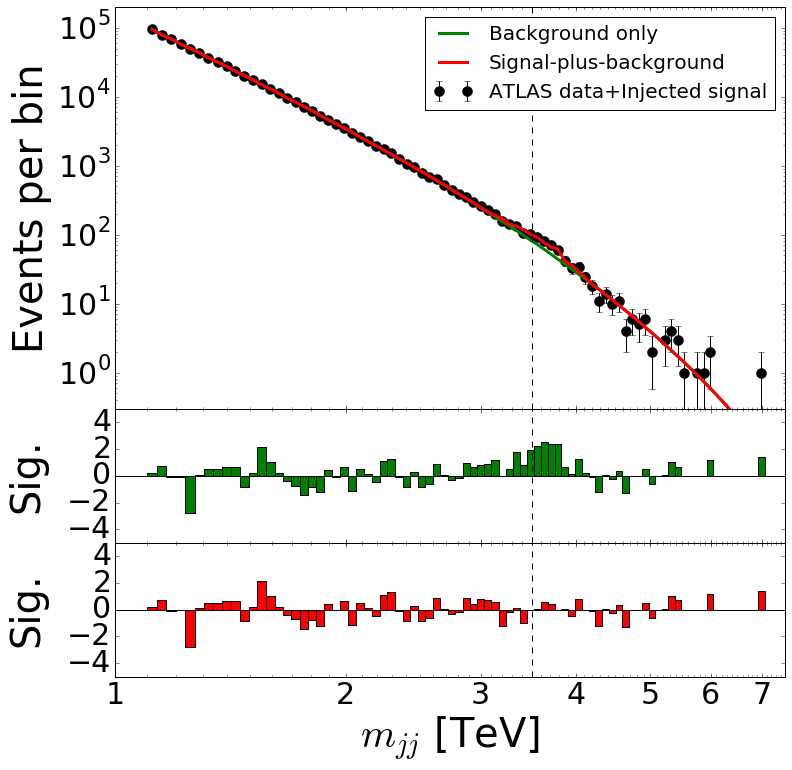

(70, 4000, 250)
chi2 bkg+signal mu=0 86.2530558662
chi2 bkg+signal 64.6347956087


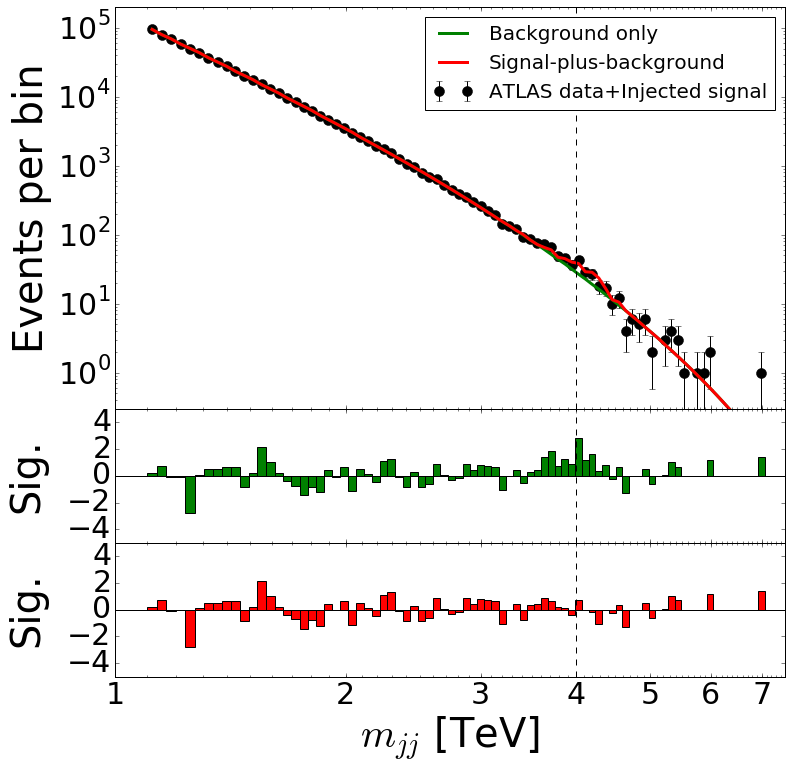

(40, 4500, 250)
chi2 bkg+signal mu=0 80.01779465
chi2 bkg+signal 64.2686969662


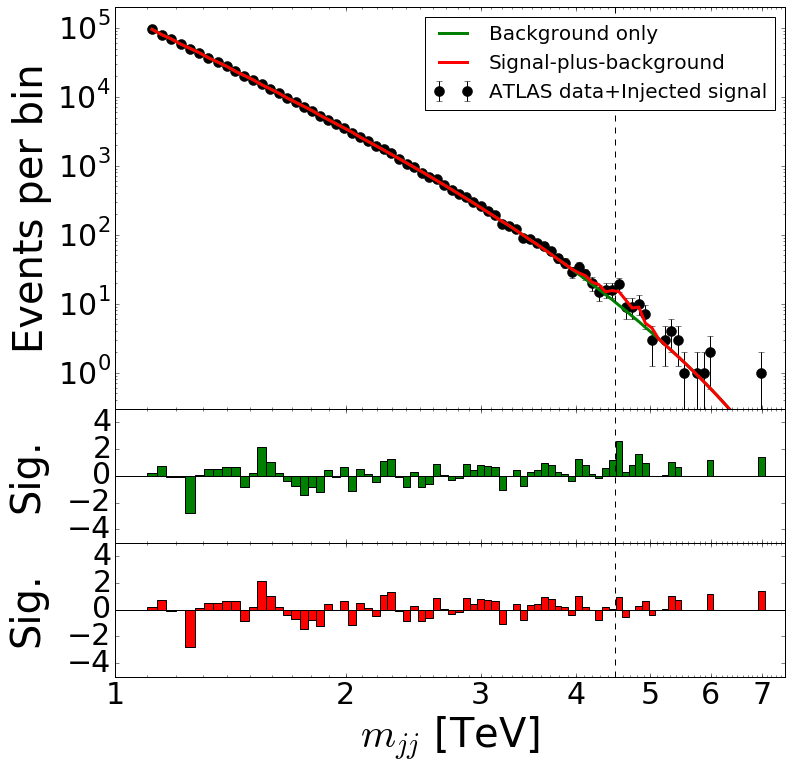

(25, 5000, 250)
chi2 bkg+signal mu=0 140.533245009
chi2 bkg+signal 61.7132956055


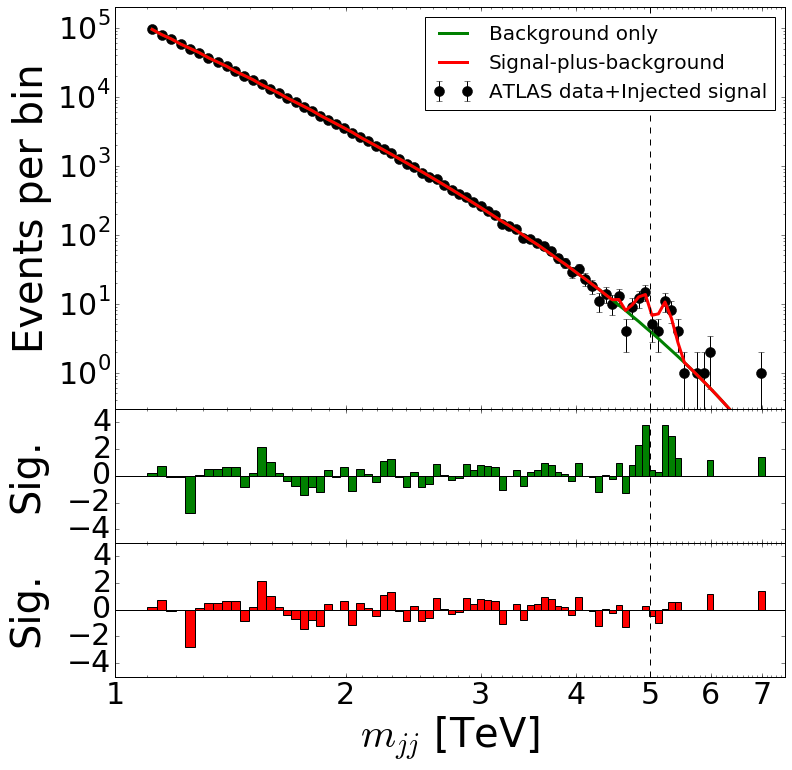

(15, 5500, 250)
chi2 bkg+signal mu=0 88.8709392233
chi2 bkg+signal 64.0002763235


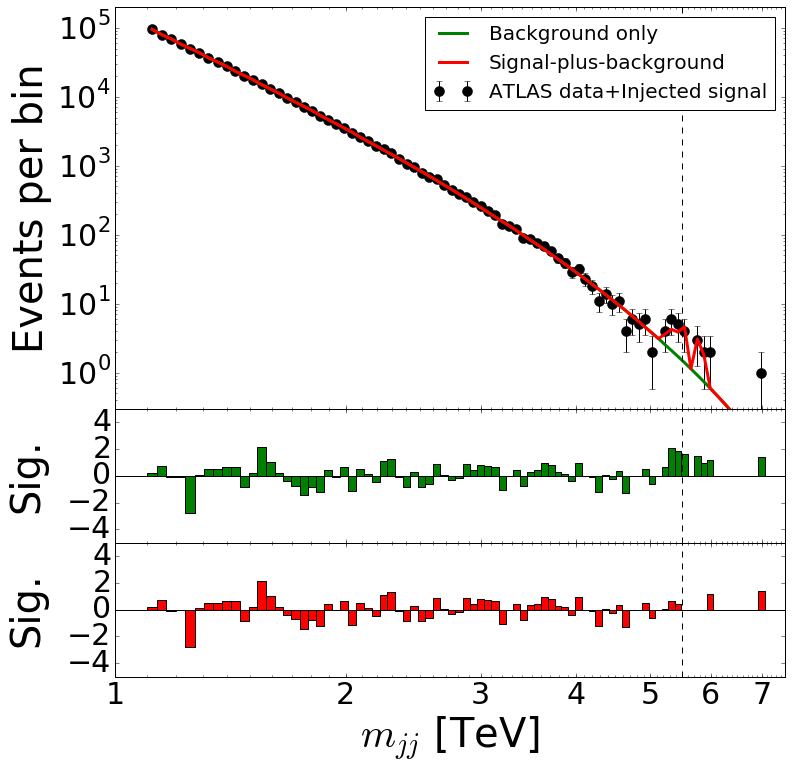

(10, 6000, 250)
chi2 bkg+signal mu=0 84.5541053259
chi2 bkg+signal 62.7004734528


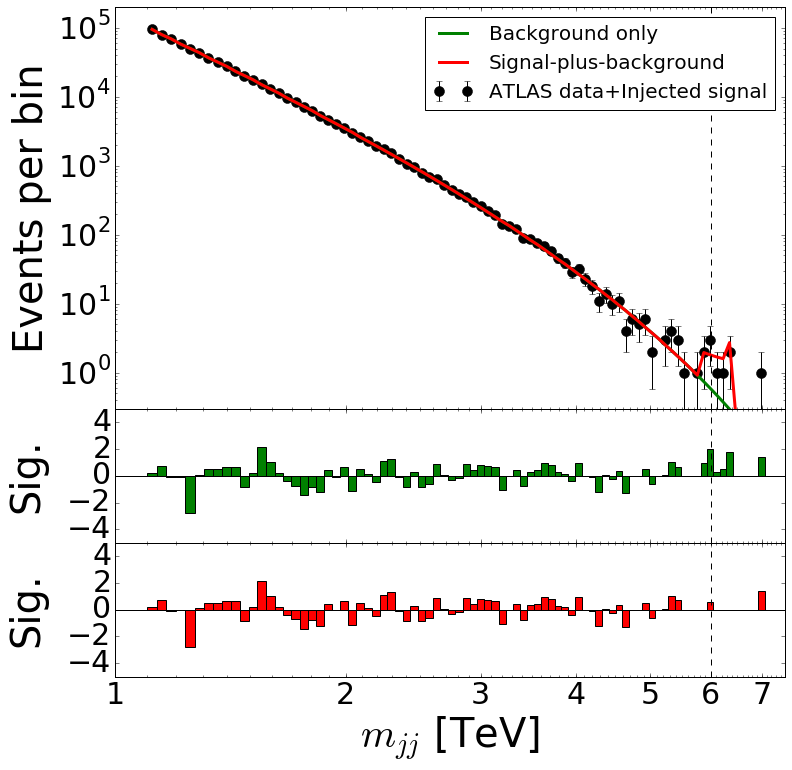

In [19]:
for pSet in standardParamSets:
    n, m, w = pSet
    print pSet

    ytoy, xtoy, xtoyerr = removeZeros(yvalO)
    signalTemplate = sig_model(xtoy, n, m, w, xtoyerr)
    signalTemplate = np.random.poisson(np.around(signalTemplate))
    ydata = ytoy + signalTemplate

    signalTemplateO = sig_model(xvalO, n, m, w, xerrO)
    signalTemplateO = np.random.poisson(np.around(signalTemplateO))
    ydataO = yvalO + signalTemplateO

    #BACKGROUND ONLY FIT GP
    Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
    kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
    gp1 = george.GP(kernel1)
    gp1.compute(xtoy, np.sqrt(ydata))
    MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
    MAP1 = MAP1p + model_3param(xvalO,(p0,p1,p2),xerrO)
    gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))

    lnProb = logLike_gp_tempSig_fixedH(xtoy,ydata, xtoyerr, signalTemplate)
    minimumLLH, best_fit_gp = fit_gp_tempSig_fixedH_minuit(lnProb, False)
    if np.isinf(minimumLLH): continue
    mu = best_fit_gp[0]

        
    kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
    gp = george.GP(kernel)
    gp.compute(xtoy, np.sqrt(ydata))
    MAPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate, xvalO)
    MAP = MAPp+ model_3param(xvalO,(p0,p1,p2),xerrO)
    MAPsig = MAP+mu*signalTemplateO
    gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate)
    makePrettyPlots_signal(xvalO, ydataO, MAP, MAPsig, "", m, col = 'g', ymax = 2e5)


In [22]:
if runOnlyFF: pass
else: 
    btime=time.time()

    #LLH ratio george likelihood
    LLlistGP={}
    #LLH ratio poisson likelihood
    LLlistGPP={}
    #signal strength 
    muListGP={}


    for pSet in standardParamSets:
        n, m, w = pSet
        print pSet
        LLlistGP[m]=[]
        LLlistGPP[m]=[]

        muListGP[m]=[]
        
        for itoy, toy in enumerate(toyList):
            if not itoy%500: 
                print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
            signalTemplate = sigToys[()][m][itoy]
            ydata = ytoy + signalTemplate

            signalTemplateO = sigToysO[()][m][itoy]
            ydataO = toy + signalTemplateO

            #BACKGROUND ONLY FIT GP
            if not itoy%500:
                pgpb_stime = time.time()
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            gp1 = george.GP(kernel1)
            gp1.compute(xtoy, np.sqrt(ydata))
            MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP1 = MAP1p + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
            if not itoy%500:
                pgpb_etime = time.time()
                print "background only time:", pgpb_etime-pgpb_stime

            #BACKGROUND+SIGNAL FIT GP
            if not itoy%500:
                pgpsb_stime = time.time()
            lnProb = logLike_gp_tempSig_fixedH(xtoy,ydata, xtoyerr, signalTemplate)
            minimumLLH, best_fit_gp = fit_gp_tempSig_fixedH_minuit(lnProb, False)
            if np.isinf(minimumLLH): continue
            mu = best_fit_gp[0]
            muListGP[m].append(mu)
        
            kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            gp = george.GP(kernel)
            gp.compute(xtoy, np.sqrt(ydata))
            MAPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate, xvalO)
            MAP = MAPp+ model_3param(xvalO,(p0,p1,p2),xerrO)
            MAPsig = MAP+mu*signalTemplateO
            gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr) - mu*signalTemplate)
            if not itoy%500:
                pgpsb_etime = time.time()
                print "background + signal time:", pgpsb_etime - pgpsb_stime
                makePrettyPlots_signal(xvalO, ydataO, MAP, MAPsig, "GP signal+background", col = 'g', ymax = 2e5)
        

            LLlistGP[m].append(-2*(gpLLH-gpLLHSig))
            LLlistGPP[m].append(-2*(-logLike_gpLikeFF(ydataO, MAP1)+logLike_gpLikeFF(ydataO, MAPsig)))

    etime = time.time()
    print "took "+str((etime-btime)/(60.*60.)) + "hours"  

(2000, 2000, 250)
0


ValueError: operands could not be broadcast together with shapes (78,) (90,) 

### fit 3 parameter fit function with and without signal component on toys with injected signal. Fit all 3 background parameters and signal strength

In [55]:
if runOnlyGP: pass
else:
    btime=time.time()

    #poisson likelihood
    LLlistFF={}
    muListFF={}

    #save fit function parameters
    paramlistFF_b={}
    paramlistFF_sb={}
    
    for pSet in standardParamSets:
        n, m, w = pSet
        print pSet
    
        LLlistFF[m]=[]
        muListFF[m]=[] 

        paramlistFF_b[m]=[]
        paramlistFF_sb[m]=[]
        
        for itoy, toy in enumerate(toyList):
            if not itoy%100: 
                print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
        

            signalTemplateO = sigToysO[()][m][itoy]
            ydataO = toy + signalTemplateO
        
            #######################################################
            if not itoy%500:
                p3b_stime = time.time()
            #BACKGROUND ONLY 3 PARAM FIT
            lnProb = logLike_3ff(xvalO, ydataO ,xerrO)
            ll_b3, best_fit_params_b3 = fit_3ff(lnProb, False)
            if not itoy%500:
                p3b_etime = time.time()
                print "background only 3 param: ", p3b_etime - p3b_stime
            paramlistFF_b[m].append(best_fit_params_b3)
            ########################################
            if not itoy%500:
                p3sb_stime = time.time()
            #BACKGROUND+SIGNAL 3 PARAM FIT
            lnProb = logLike_3ff_sig(xvalO, ydataO, xerrO, signalTemplateO)
            ll_sb3, best_fit_params_sb3 = fit_3ff_sig(lnProb, False)
            if (np.isinf(ll_sb3) or np.isinf(ll_b3)): continue
            mu3=best_fit_params_sb3[-1]
            paramlistFF_sb[m].append(best_fit_params_sb3)

            LLlistFF[m].append(-2*(-ll_b3+ll_sb3))
            muListFF[m].append(mu3*n)

            if not itoy%500:
                p3sb_etime = time.time()
                print "s+b 3 param: ", p3sb_etime - p3sb_stime

            
            
    etime = time.time()
    print "took "+str((etime-btime)/(60.*60.)) + "hours"  

(2000, 2000, 250)
0
background only 3 param:  1.10512804985
s+b 3 param:  2.11808609962
100
200
300
400
500
background only 3 param:  0.55385184288
s+b 3 param:  2.21688103676
600
700
800
900
1000
background only 3 param:  1.61001420021
s+b 3 param:  1.90949606895
1100
1200
1300
1400
1500
background only 3 param:  1.5736849308
s+b 3 param:  1.44231510162
1600
1700
1800
1900
2000
background only 3 param:  0.861256122589
s+b 3 param:  1.3832461834
2100
2200
2300
2400
2500
background only 3 param:  0.68238401413
s+b 3 param:  2.85257697105
2600
2700
2800
2900
3000
background only 3 param:  0.863032817841
s+b 3 param:  2.03329014778
3100
3200
3300
3400
3500
background only 3 param:  0.964179992676
s+b 3 param:  1.46295690536
3600
3700
3800
3900
4000
background only 3 param:  0.749575853348
s+b 3 param:  2.04467582703
4100
4200
4300
4400
4500
background only 3 param:  0.502567052841
s+b 3 param:  1.73260188103
4600
4700
4800
4900
5000
background only 3 param:  0.906880140305
s+b 3 param:  1

### Distribution of log likelihood ratio for Gaussian Process from george and Poisson likelihood calculations, with non central chi2 overlaid

george, poisson % < 0:  0.0 , 0.0 nc  [ 23.20621488]
nc  [ 24.58364701]


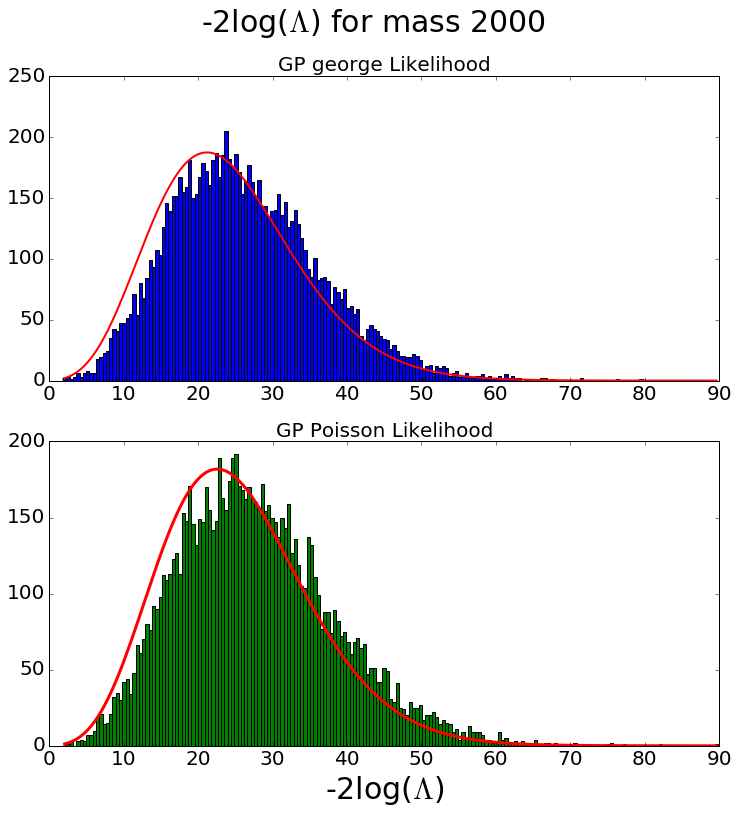

george, poisson % < 0:  0.0 , 0.0 nc  [ 18.06755402]
nc  [ 20.13708817]


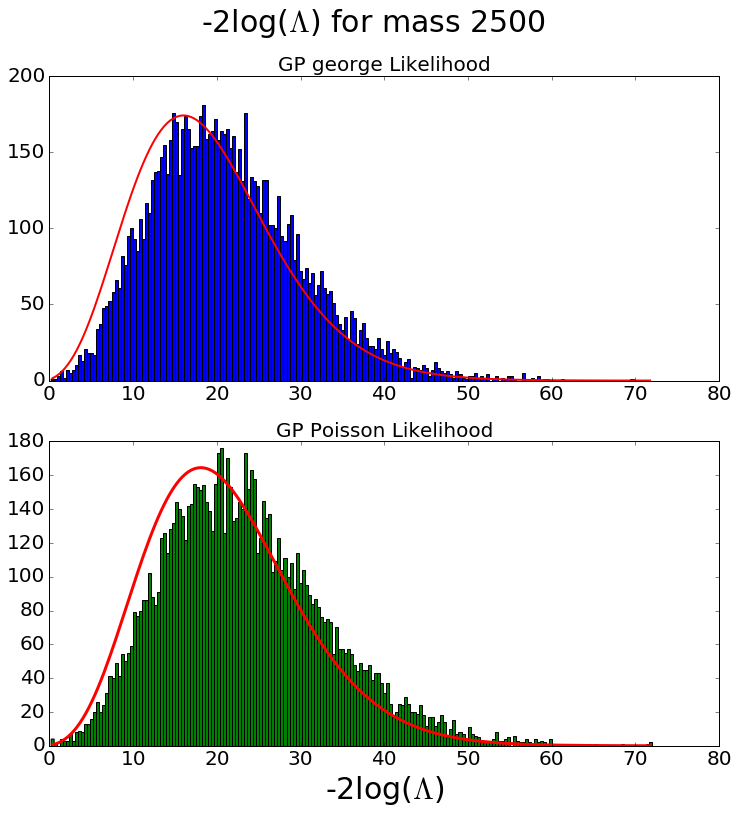

george, poisson % < 0:  0.0 , 0.0 nc  [ 16.954879]
nc  [ 19.8397745]


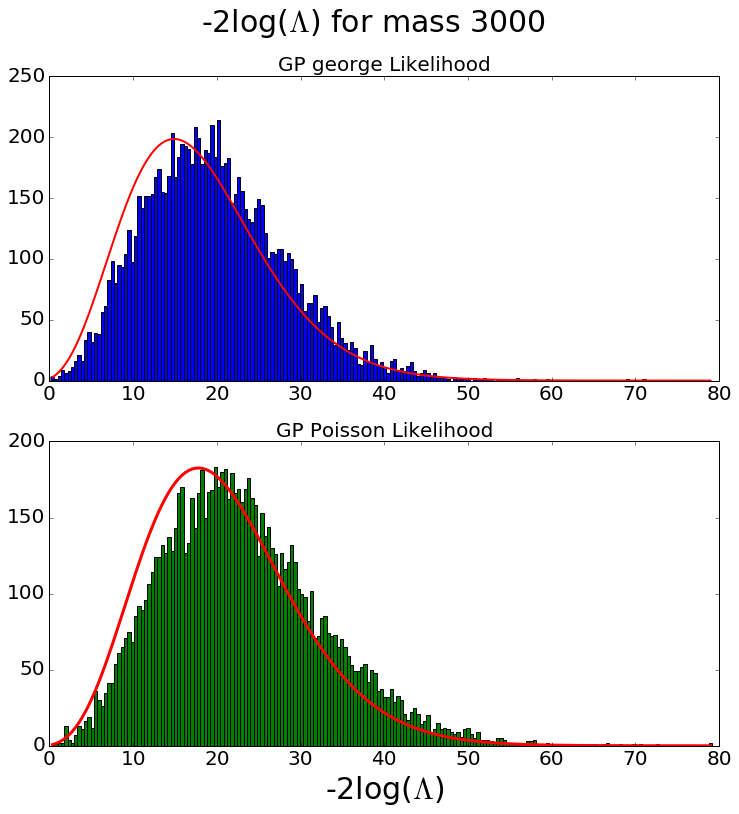

george, poisson % < 0:  0.0 , 0.0 nc  [ 16.91899655]
nc  [ 21.38108383]


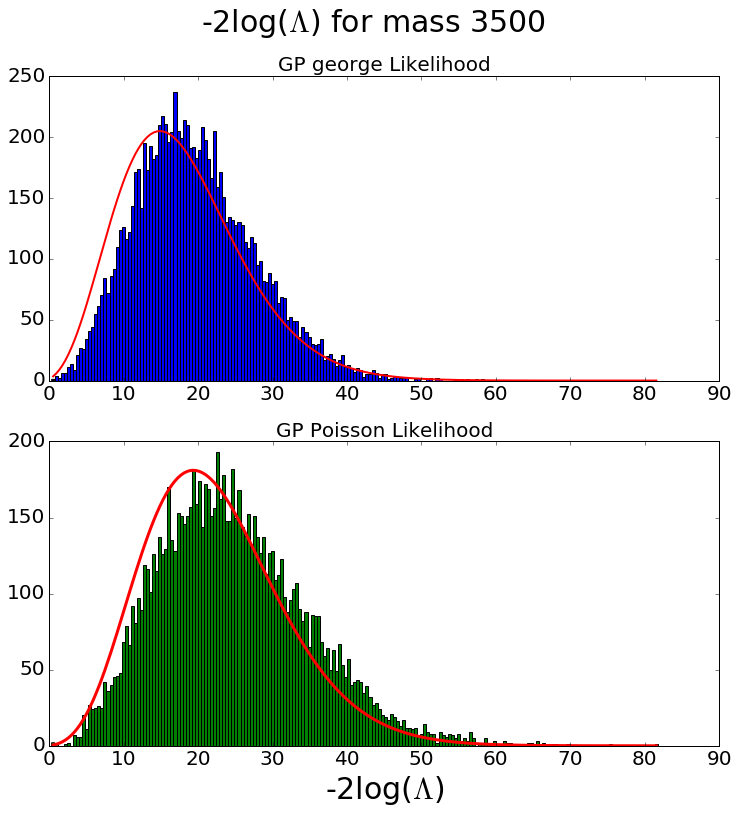

george, poisson % < 0:  0.0 , 0.03 nc  [ 13.18833682]
nc  [ 18.93815964]


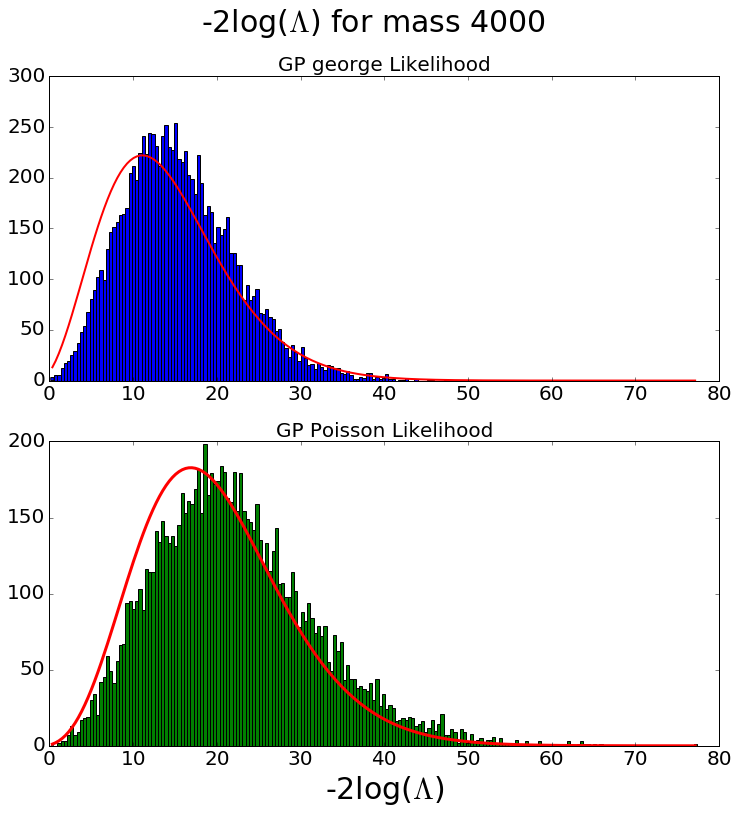

george, poisson % < 0:  0.01 , 0.01 nc  [ 9.12743346]
nc  [ 15.39166113]


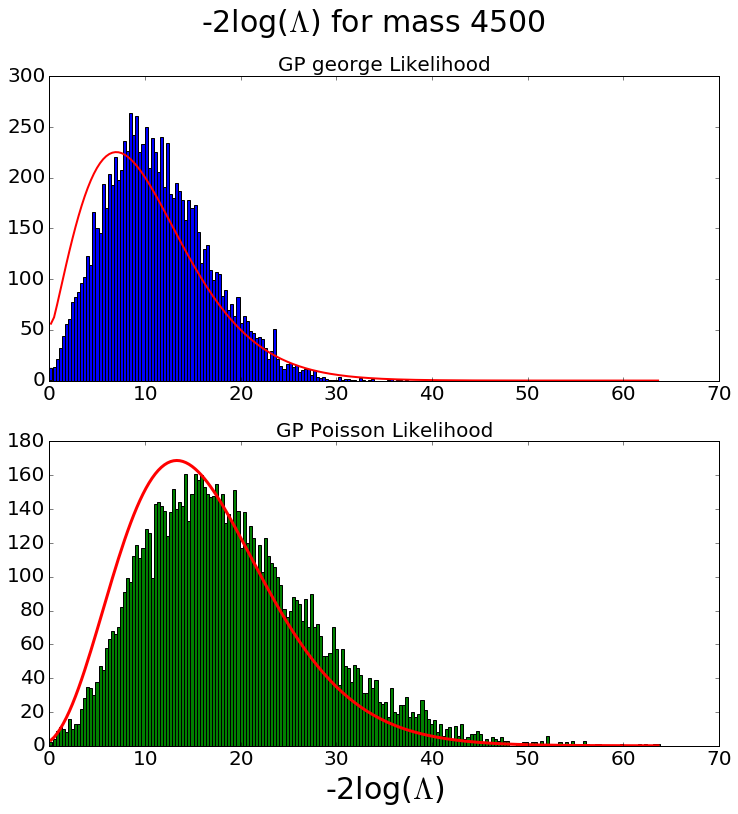

george, poisson % < 0:  0.0 , 0.04 nc  [ 8.47357515]
nc  [ 16.24746938]


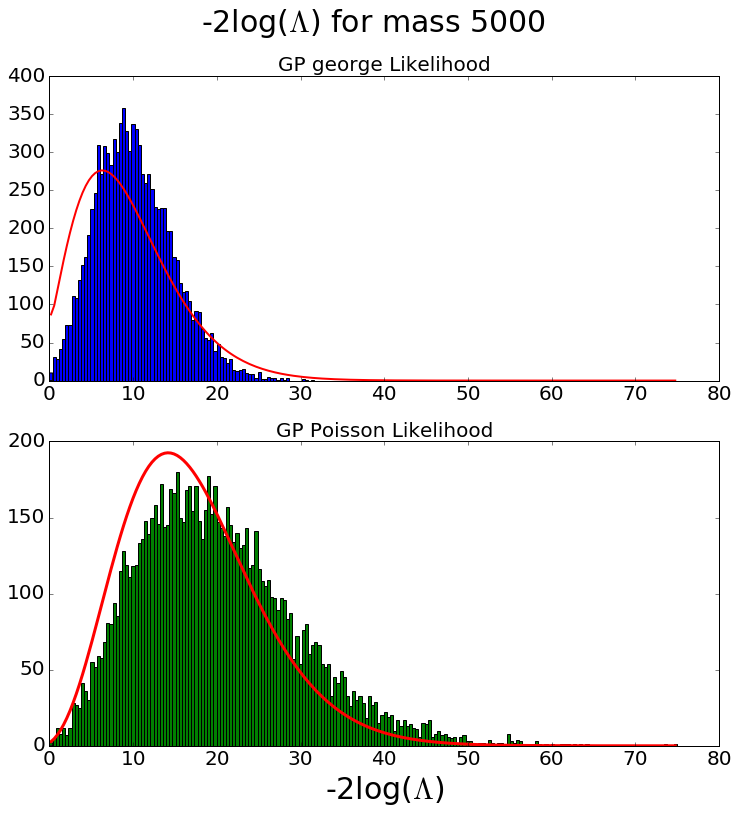

george, poisson % < 0:  0.04 , 0.26 nc  [ 6.35140077]
nc  [ 15.34860425]


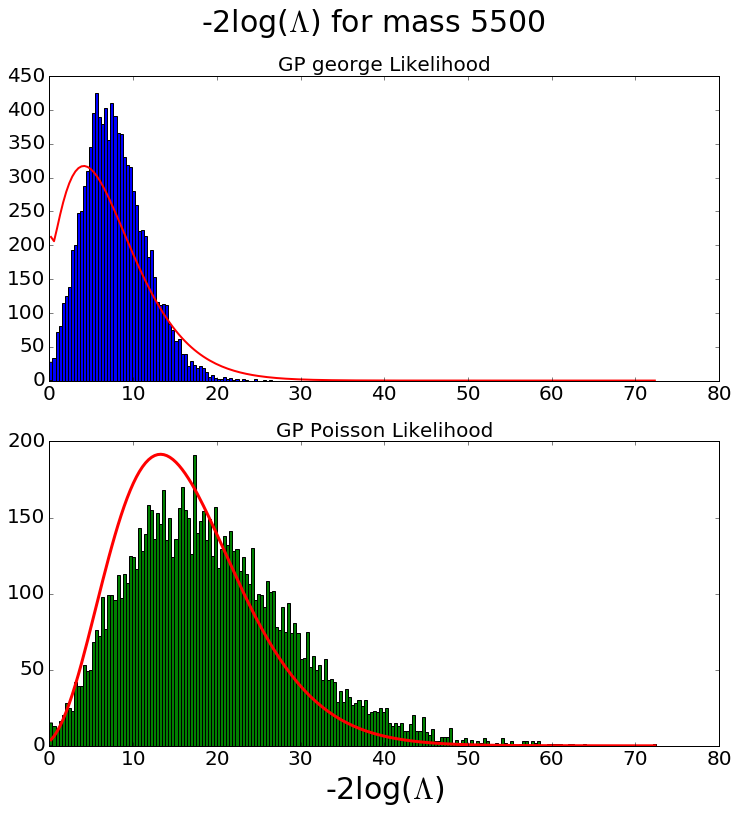

george, poisson % < 0:  0.0 , 0.85 nc  [ 3.94065816]
nc  [ 17.06612913]


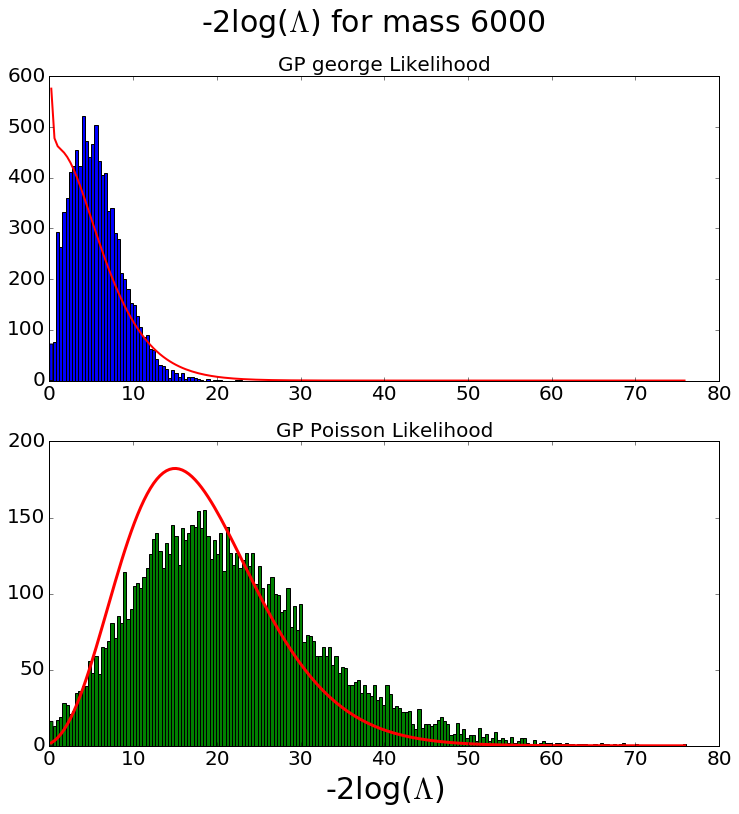

[[array([ 23.20621488]), array([ 4.81728294])], [array([ 18.06755402]), array([ 4.25059455])], [array([ 16.954879]), array([ 4.11763027])], [array([ 16.91899655]), array([ 4.11327079])], [array([ 13.18833682]), array([ 3.63157498])], [array([ 9.12743346]), array([ 3.02116426])], [array([ 8.47357515]), array([ 2.9109406])], [array([ 6.35140077]), array([ 2.52019856])], [array([ 3.94065816]), array([ 1.9851091])]]


In [20]:
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
GPlist=[]
GPlistP=[]

GPlist_chi=[]
GPlistP_chi=[]
for m in msignals:

    '''
    gp = [s for s in LLlistGP[m] if not (np.isinf(s) or np.isnan(s))]
    P = [s for s in LLlistGPP[m] if not (np.isinf(s) or np.isnan(s))]
    
    np.save("newoutputs/LLHR_GP_Poisson_"+str(m)+"_withSignal.npy", P)
    np.save("newoutputs/LLHR_GP_george_"+str(m)+"_withSignal.npy", gp)
    np.save("newoutputs/LLHR_GP_N_"+str(m)+".npy", muListGP[m])
    
    '''
    P=np.load("newoutputs/LLHR_GP_Poisson_"+str(m)+"_withSignal.npy")
    gp=np.load("newoutputs/LLHR_GP_george_"+str(m)+"_withSignal.npy")
    
    
    gp_neg_frac = round(100.*sum(i < 0 for i in gp)/len(gp),2)
    gpP_neg_frac = round(100.*sum(i < 0 for i in P)/len(P),2)
    
    print "george, poisson % < 0: ", gp_neg_frac, ",", gpP_neg_frac,
    
    GPlist.append([np.median(np.array(gp)), np.std(np.array(gp))])
    GPlistP.append([np.median(np.array(P)), np.std(np.array(P))])

    gp = [s for s in gp if s > 0]
    P = [s for s in P if s > 0]
    
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    nc_gp, nc_P = makePrettyPlots_LLH(gp, P, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 ="GP george Likelihood", label2 = "GP Poisson Likelihood")
    
    mean_chi2_gp, std_chi2_gp = chi2_mean_variance(len(gp), nc_gp)
    mean_chi2_P, std_chi2_P = chi2_mean_variance(len(P), nc_P)
    
    GPlist_chi.append([mean_chi2_gp, std_chi2_gp])
    GPlistP_chi.append([mean_chi2_P, std_chi2_P])
print GPlist_chi

### Distribution of log likelihood ratio for 3 parameter fit function, with non central chi2 overlaid

3 parameter poisson, poisson with no lngamma, gaussian % < 0:  0.13
nc  [ 9.5951575]
nc  [ 9.5951575]


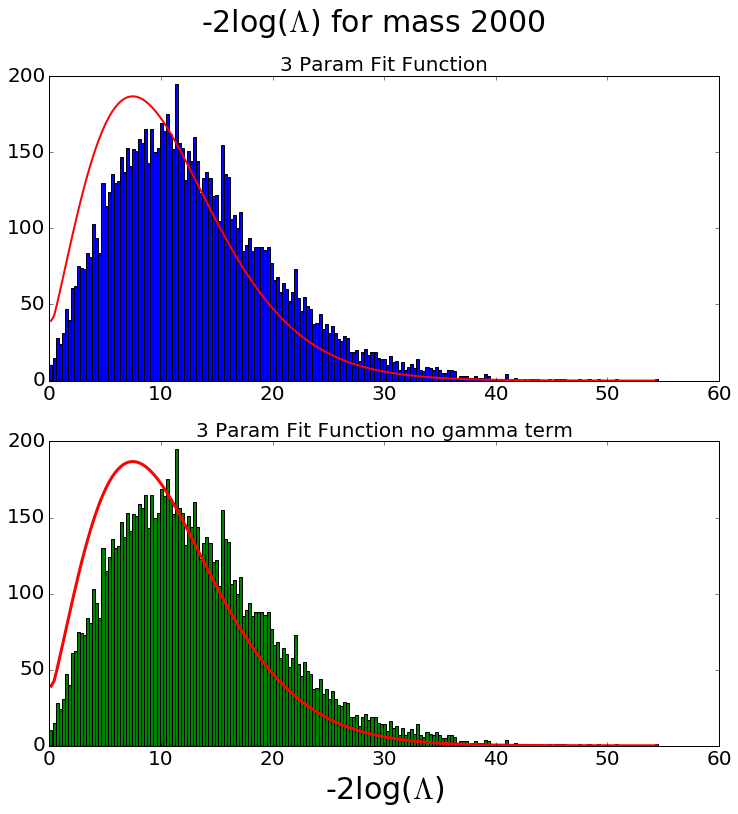

3 parameter poisson, poisson with no lngamma, gaussian % < 0:  0.03
nc  [ 17.29260671]
nc  [ 17.29260671]


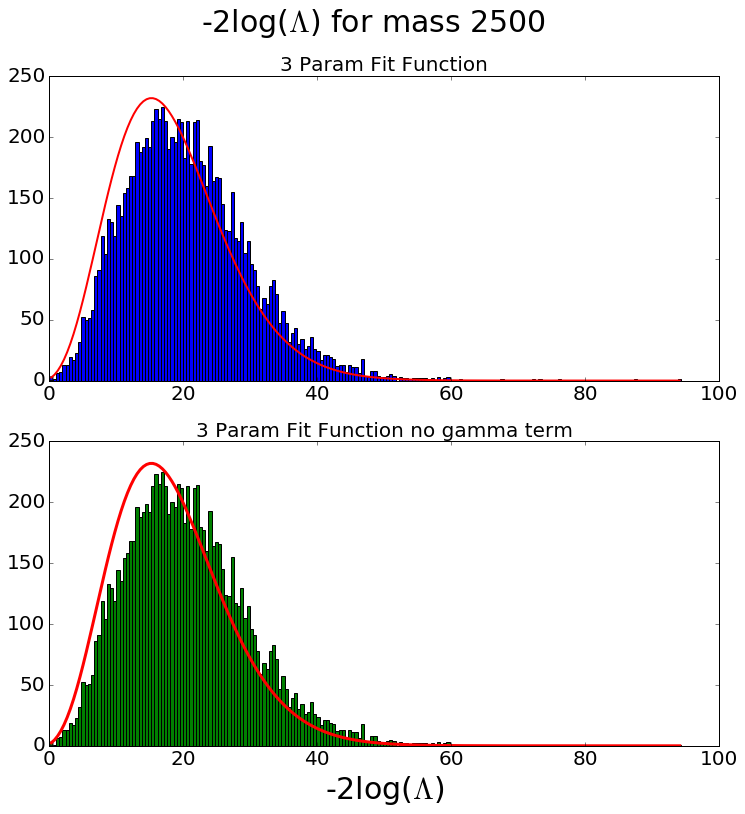

3 parameter poisson, poisson with no lngamma, gaussian % < 0:  0.05
nc  [ 22.67642014]
nc  [ 22.67642014]


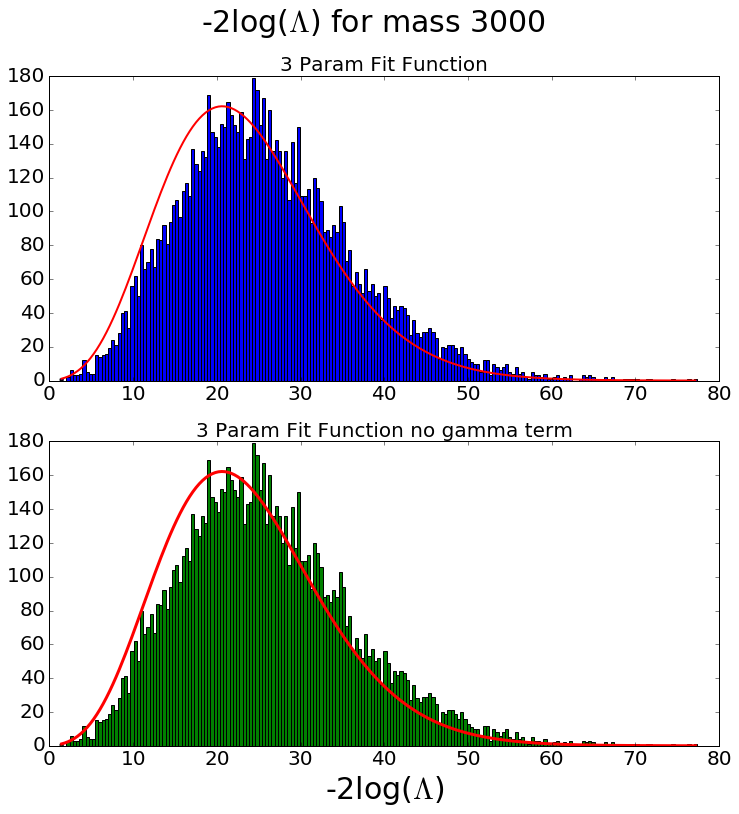

3 parameter poisson, poisson with no lngamma, gaussian % < 0:  0.06
nc  [ 23.70649308]
nc  [ 23.70649308]


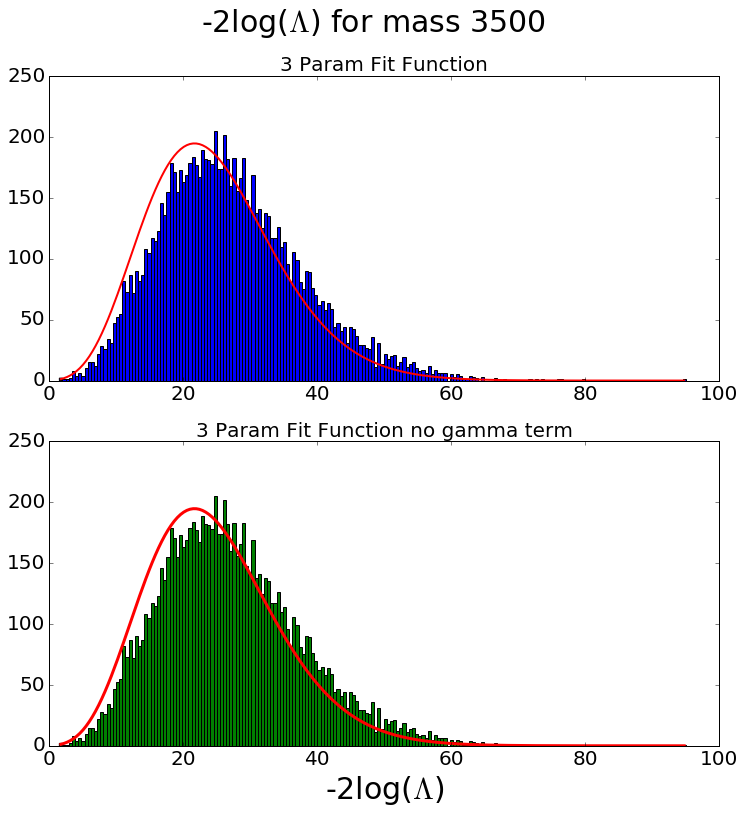

3 parameter poisson, poisson with no lngamma, gaussian % < 0:  0.05
nc  [ 20.31627659]
nc  [ 20.31627659]


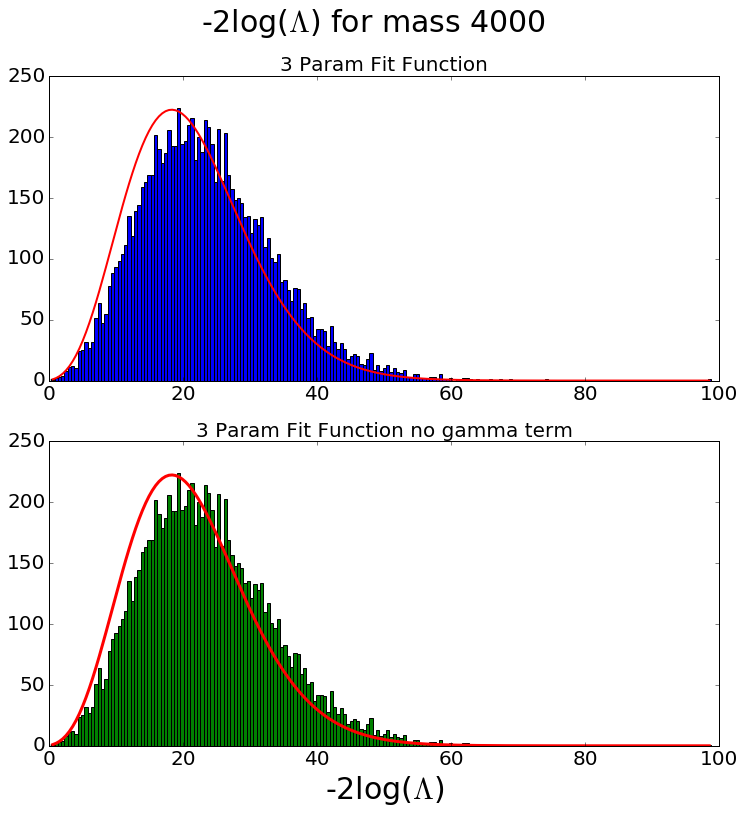

3 parameter poisson, poisson with no lngamma, gaussian % < 0:  0.22
nc  [ 16.16410576]
nc  [ 16.16410576]


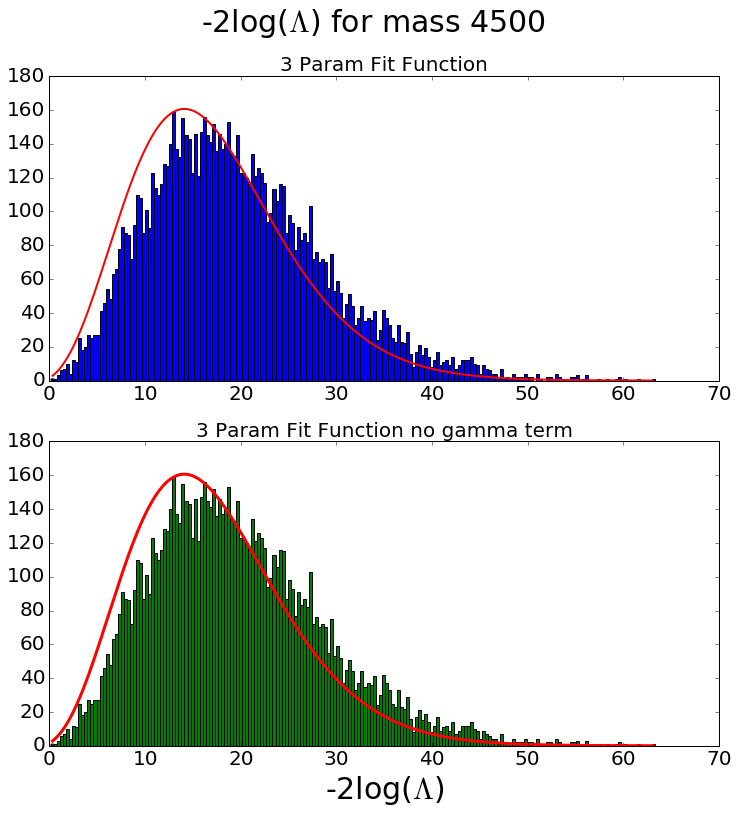

3 parameter poisson, poisson with no lngamma, gaussian % < 0:  0.28
nc  [ 16.86308787]
nc  [ 16.86308787]


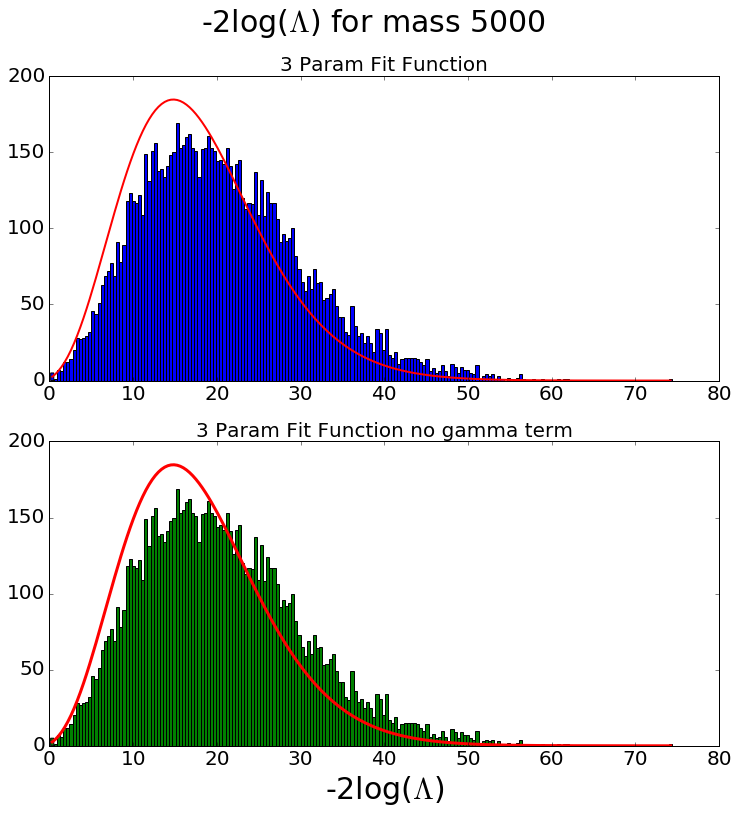

3 parameter poisson, poisson with no lngamma, gaussian % < 0:  0.64
nc  [ 15.90525461]
nc  [ 15.90525461]


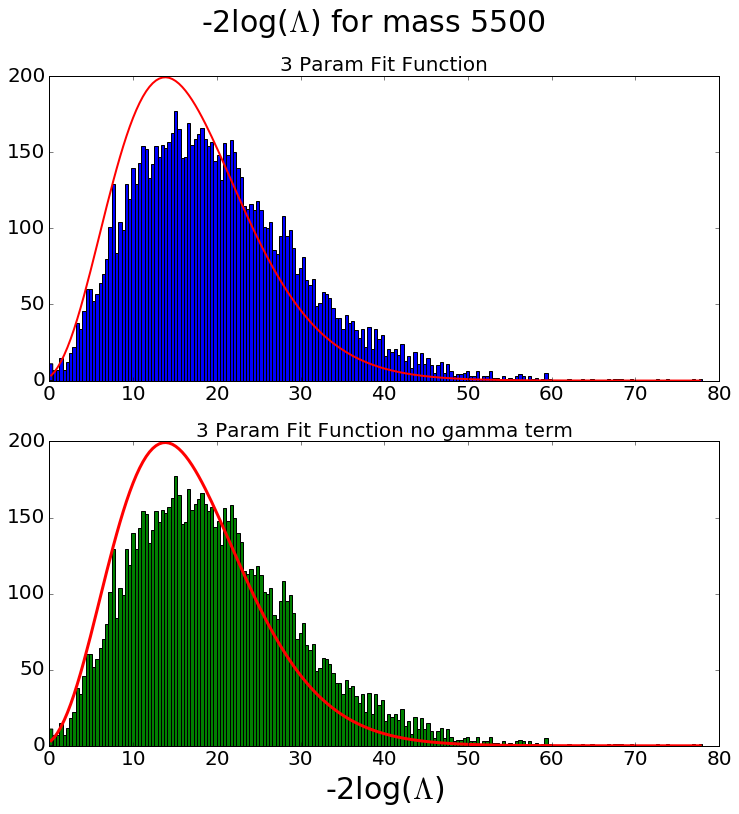

3 parameter poisson, poisson with no lngamma, gaussian % < 0:  0.51
nc  [ 18.06787439]
nc  [ 18.06787439]


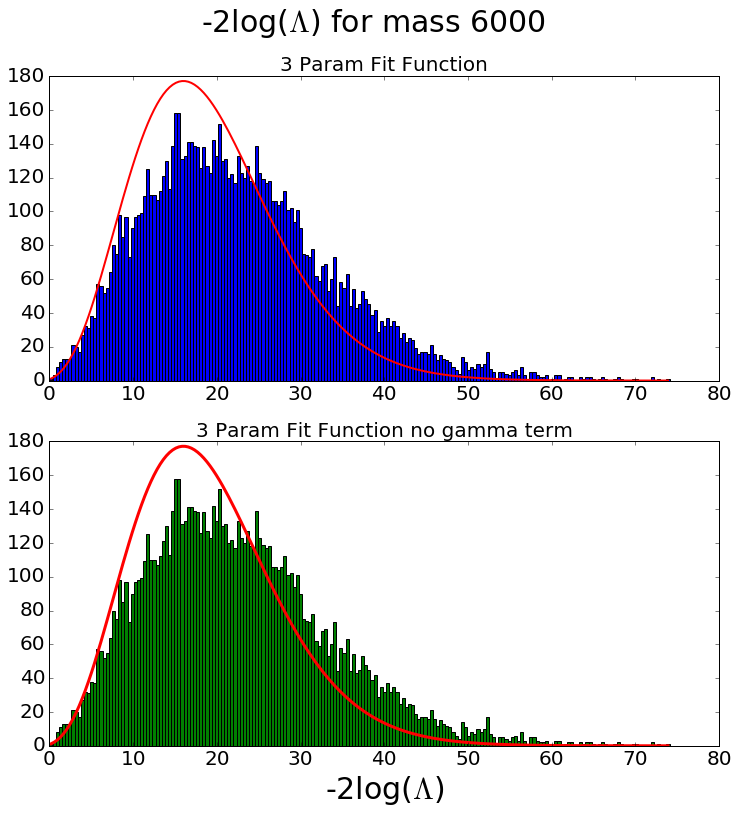

In [21]:
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]

FFlist3=[]
FFlist3_chi=[]
for m in msignals:

    '''
    ff = [s for s in LLlistFF[m] if not (np.isinf(s) or np.isnan(s))]
    np.save("newoutputs/LLHR_FF_"+str(m)+"_withSignal.npy", ff)
    np.save("newoutputs/LLHR_FF_N_"+str(m)+".npy", listFF_N[m])
    '''
    ff=np.load("newoutputs/LLHR_FF_"+str(m)+"_withSignal.npy")
    
    ff_neg_frac = round(100.*sum(i < 0 for i in ff)/len(ff),2)
    
    print "3 parameter poisson, poisson with no lngamma, gaussian % < 0: ", ff_neg_frac
    
    FFlist3.append([np.median(np.array(ff)), np.std(np.array(ff))])
    
    ff = [s for s in ff if s > 0]
    
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    nc_ff, nc_ng = makePrettyPlots_LLH(ff, ff, label, drawchi2=True, xname =r"-2log($\Lambda$)", label1="3 Param Fit Function", label2 = "3 Param Fit Function no gamma term" )

        
    mean_chi2_ff, std_chi2_ff = chi2_mean_variance(len(ff), nc_ff)    
    FFlist3_chi.append([mean_chi2_ff, std_chi2_ff])


### Plot best fit parameters for fit function

In [23]:
def plotBestFitParams(paramList, paramNames, title):
    f, ax = plt.subplots(1, len(paramList[0]), figsize=(15,5))
    f.suptitle(title, fontsize=20, y = 1.08)
    paramList = [s for s in paramList if not all([True if b == 0 else False for b in s])]
    for iparam in range(len(paramList[0])):
        ax[iparam].set_xlabel(paramNames[iparam], fontsize=15)
        p = [paramList[i][iparam] for i in range(len(paramList))]
        ax[iparam].hist(p, bins=np.linspace(min(p), max(p), 50))
        ax[iparam].axvline(np.mean(p), color='r', linestyle='dashed', linewidth=2)
        ax[iparam].annotate(str(round(np.mean(p),3)), xy=(0.75, 0.75), xycoords='axes fraction')

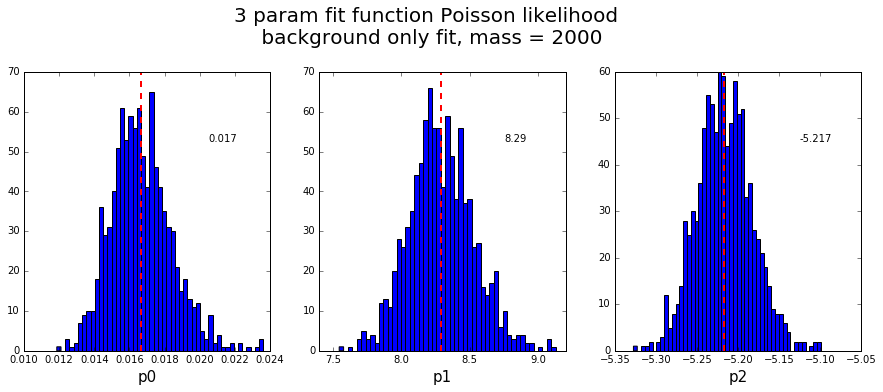

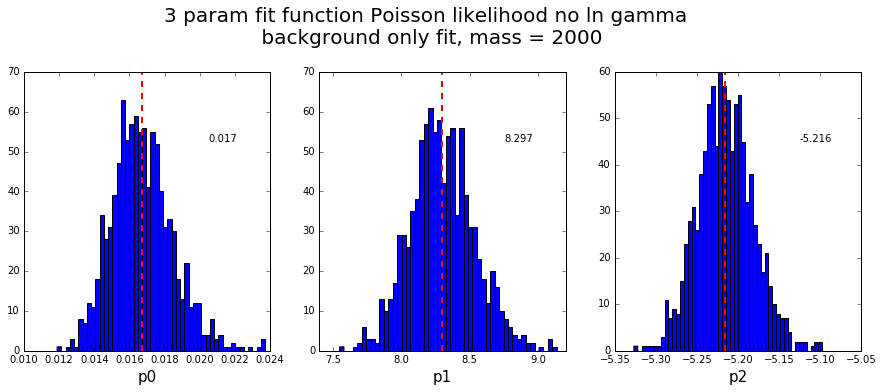

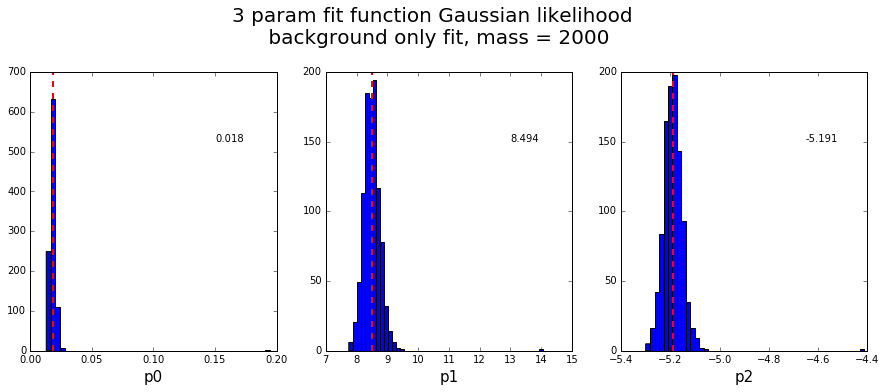

In [24]:
msignals = [2000]
for m in msignals:
    plotBestFitParams(paramlistFF_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood \n background only fit, mass = " + str(m))

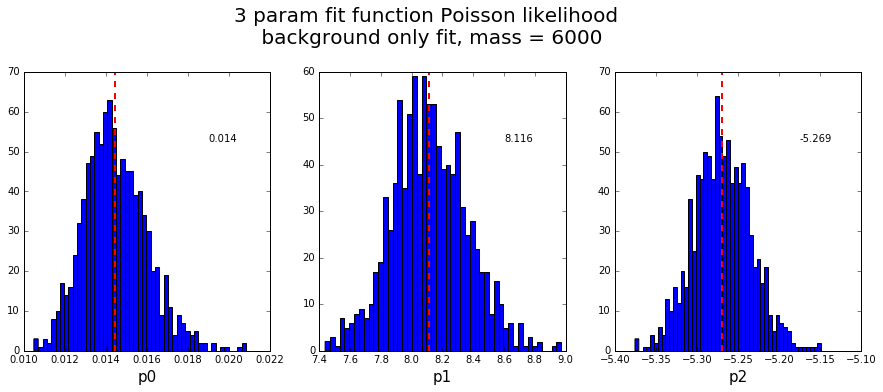

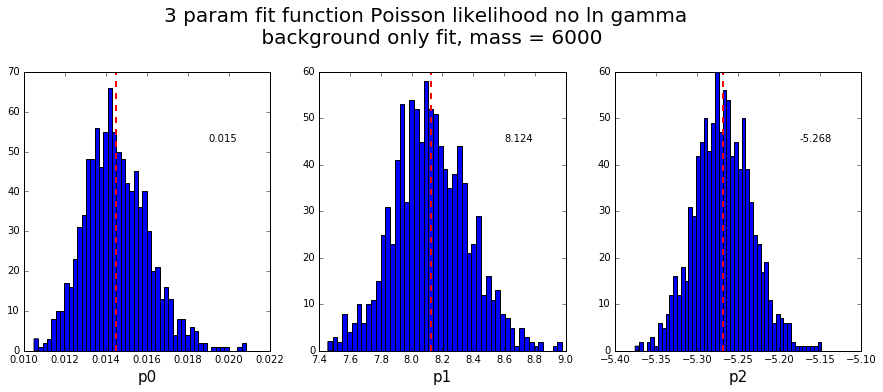

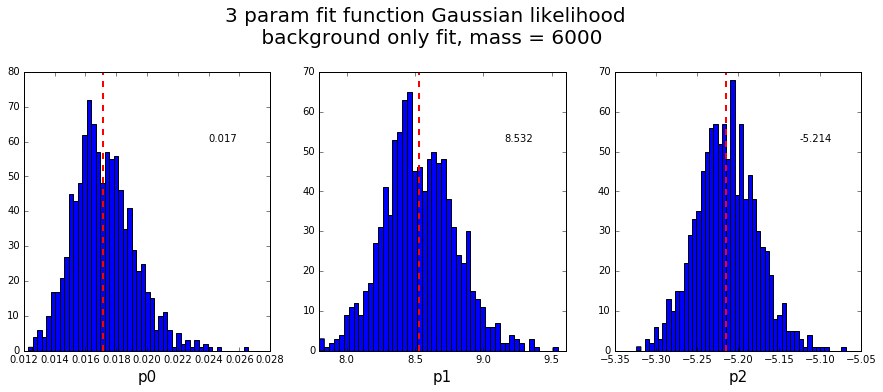

In [25]:
msignals = [6000]

for m in msignals:
    plotBestFitParams(paramlistFF_b[m], ['p0','p1','p2'], "3 param fit function Poisson likelihood \n background only fit, mass = " + str(m))

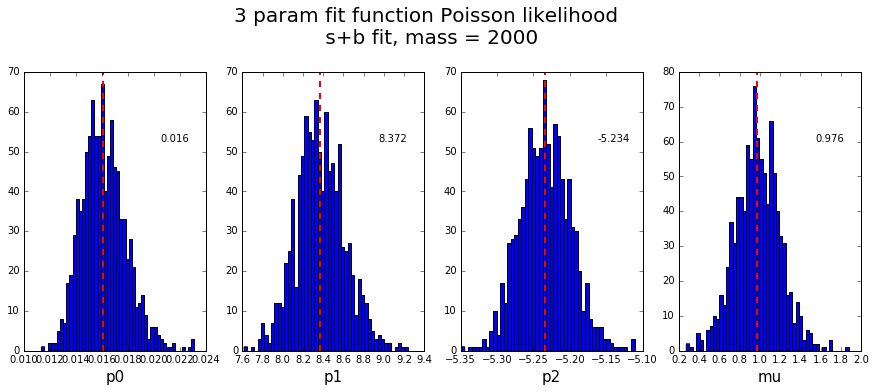

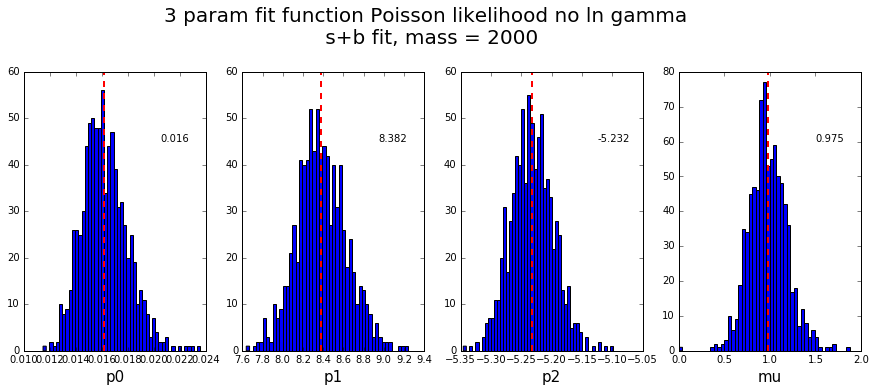

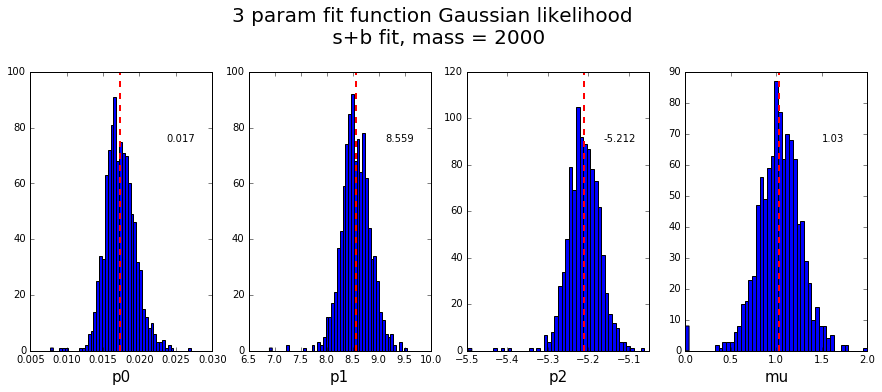

In [26]:
msignals = [2000]
for m in msignals:
    plotBestFitParams(paramlistFF_sb[m], ['p0','p1','p2', 'mu'], "3 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))

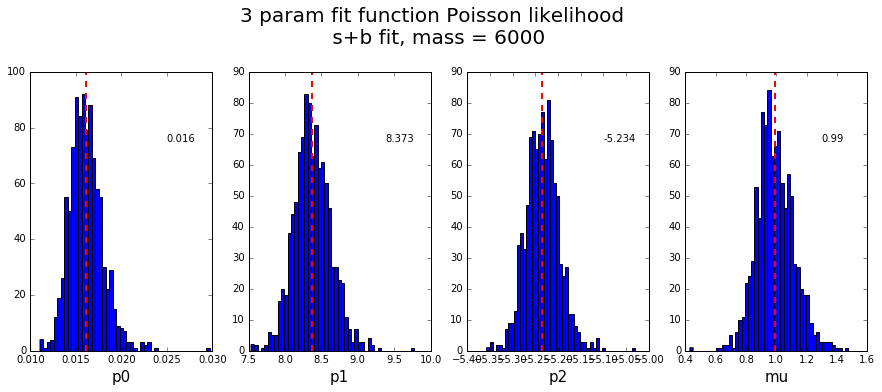

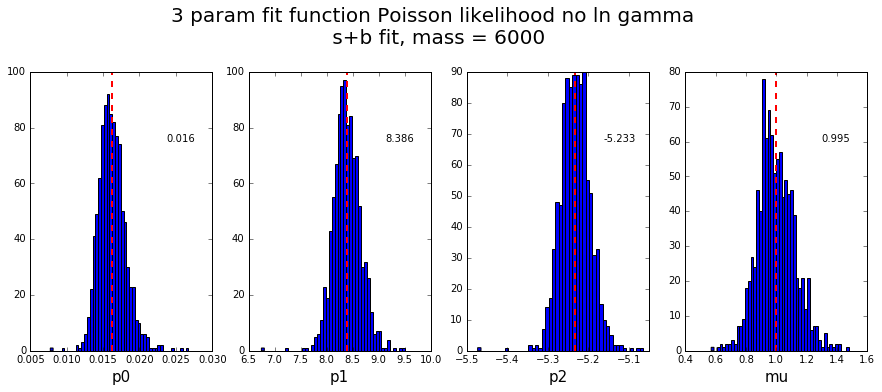

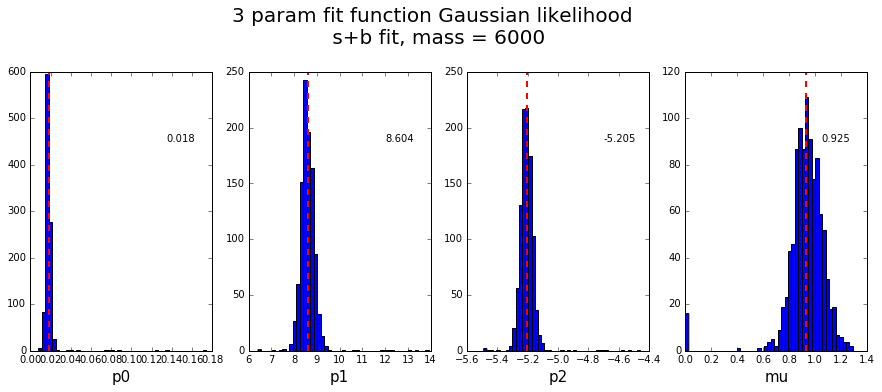

In [27]:
msignals = [6000]
for m in msignals:
    plotBestFitParams(paramlistFF_sb[m], ['p0','p1','p2', 'mu'], "3 param fit function Poisson likelihood \n s+b fit, mass = " + str(m))

In [22]:
def plot_LLH(msignals, FFList3, GPlistP):
    f, ax1 = plt.subplots(1, figsize=(12,8))
    ax1.errorbar(msignals, [FFlist3[i][0] for i in range(len(msignals))], yerr = [FFlist3[i][1] for i in range(len(msignals))], color="b", lw=3, label="ad-hoc function")
    ax1.errorbar(msignals, [GPlistP[i][0] for i in range(len(msignals))], yerr = [GPlistP[i][1] for i in range(len(msignals))], color="g", lw=3, label="Gaussian Process")
    ax1.plot([1900,6100], 9*np.ones(2), c='black', lw=2, label=r'3 $\sigma$')
    ax1.plot([1900,6100], 4*np.ones(2), c='black', ls='--', lw=2, label=r"2 $\sigma$")
    ax1.legend(loc=1, prop={'size':20})
    

    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xlim([1900, 6100])
    ax1.set_ylim([1, 1100])
    ax1.set_xlabel("True Signal Mass [GeV]", fontsize=40)
    ax1.set_ylabel(r"-2log($\Lambda$)", fontsize=40)

    ax1.tick_params(axis='y', labelsize=30)
    ax1.tick_params(axis='x', labelsize=30)


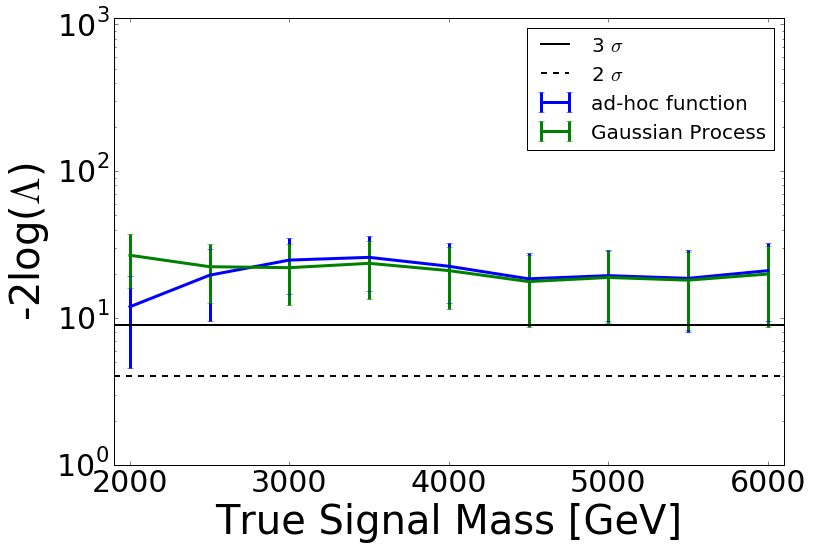

In [23]:
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]

if runOnlyGP or runOnlyFF: pass
else:
    plot_LLH(msignals, FFlist3, GPlistP)


### Distribution of signal strength parameter

In [49]:
def plotMu(m):
    f, ax = plt.subplots(1, 2, figsize=(15,5))
    f.suptitle("mu", fontsize=20, y = 1.08)
    ax[0].set_xlabel("mu", fontsize=15)
    ax[0].hist(muListGP[m], bins=np.linspace(min(muListGP[m]), max(muListGP[m]), 50))
    ax[0].axvline(np.mean(muListGP[m]), color='r', linestyle='dashed', linewidth=2)
    ax[0].annotate(str(round(np.mean(muListGP[m]),3)), xy=(0.75, 0.75), xycoords='axes fraction')

    ax[1].set_xlabel("mu", fontsize=15)
    ax[1].hist(muListFF[m], bins=np.linspace(min(muListFF[m]), max(muListFF[m]), 50))
    ax[1].axvline(np.mean(muListFF[m]), color='r', linestyle='dashed', linewidth=2)
    ax[1].annotate(str(round(np.mean(muListFF[m]),3)), xy=(0.75, 0.75), xycoords='axes fraction')

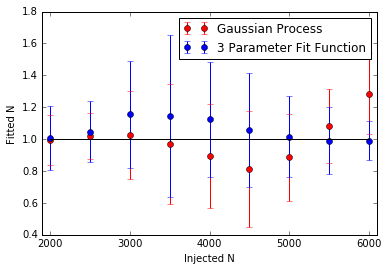

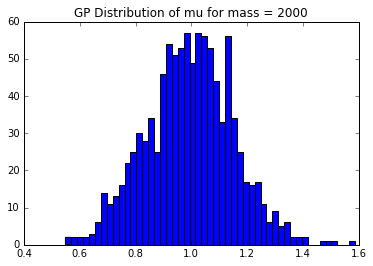

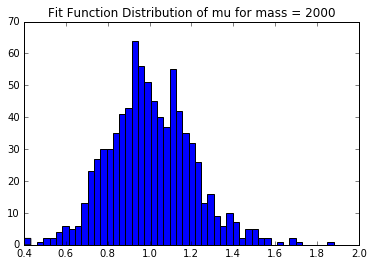

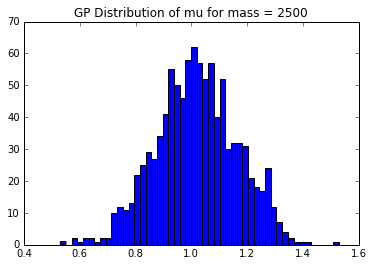

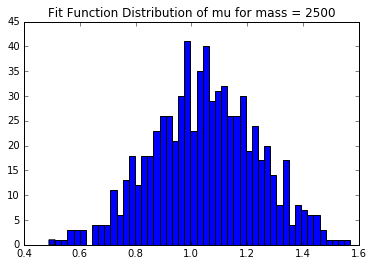

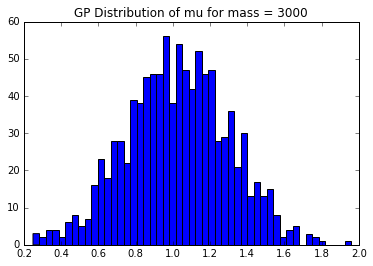

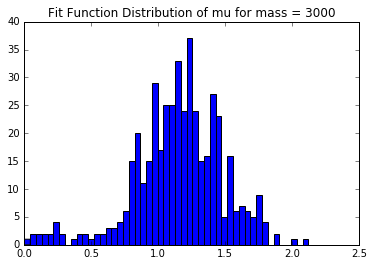

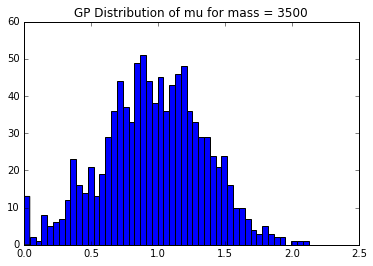

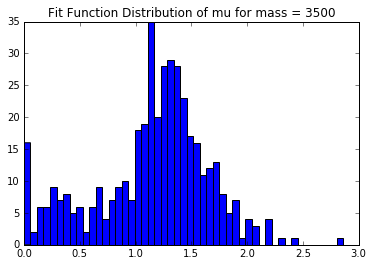

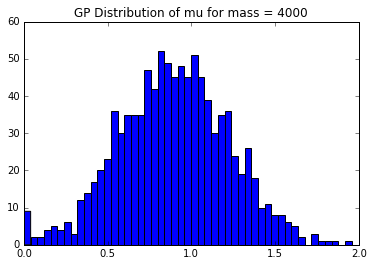

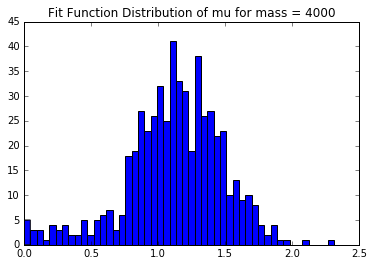

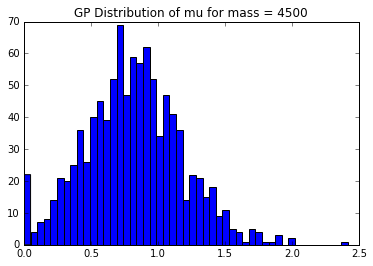

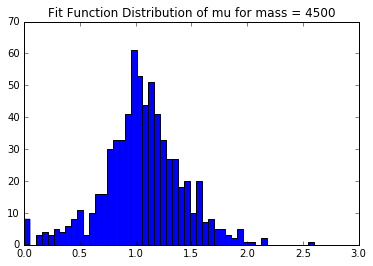

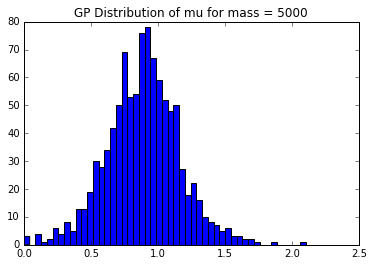

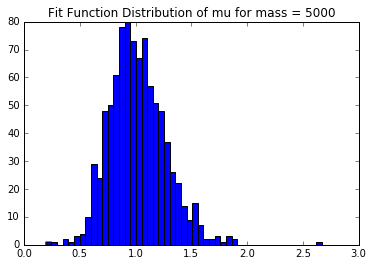

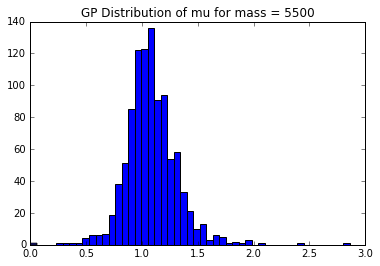

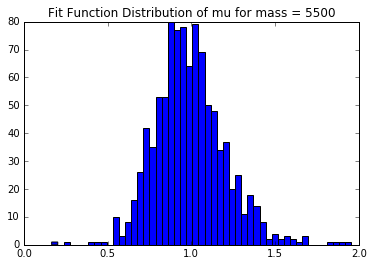

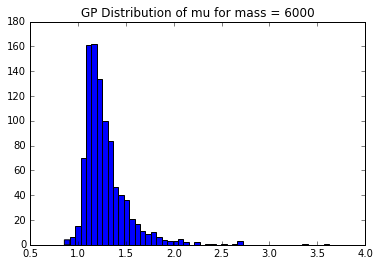

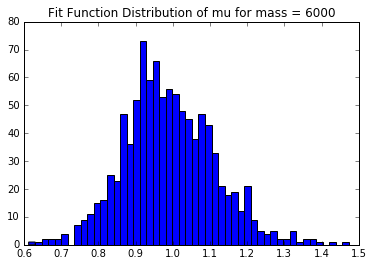

In [75]:
if runOnlyGP or runOnlyFF: pass
else:
    Nsignals = [standardParamSets[i][0] for i in range(len(standardParamSets))]
    plt.figure()
    plt.errorbar(msignals, [np.mean(muListGP[m]) for m in msignals], yerr = [np.std(muListGP[m]) for m in msignals], marker="o", linestyle="None", color="r", label="Gaussian Process")
    plt.errorbar(msignals, [np.mean(muListFF[m]) for m in msignals], yerr = [np.std(muListFF[m]) for m in msignals], marker="o", linestyle="None", color="b", label="3 Parameter Fit Function")
    plt.plot(msignals, np.ones(len(msignals)), ls='-', color='black')

    plt.xlabel("mass [GeV]")
    plt.xlim([1900, 6100])
    plt.ylabel("Fitted signal strength")
    plt.legend(loc=1)
    for m in msignals:
        plt.figure()
        plt.hist(muListGP[m], bins=np.linspace(min(muListGP[m]), max(muListGP[m]), 50))
        plt.title("GP Distribution of mu for mass = "+str(m))
        plt.figure()
        plt.hist(muListFF[m], bins=np.linspace(min(muListFF[m]), max(muListFF[m]), 50))
        plt.title("Fit Function Distribution of mu for mass = "+str(m))

### Look at injected signal events vs fitted signal events

[ 14.171869    13.40955666   8.67797004 ...,  12.56615528   9.9080629
  12.64302859] [ 10.91555298  11.08538347  10.43848498 ...,  15.94633365   8.28385762
   8.76987424]
13.9249222558 10.6685075052
0.392492225582
0.0668507505198
0.392492225582
0.0668507505198
[-0.42258729 -0.10930186  0.37419531  0.42177658  0.28603562  0.07926348
  0.03233708  0.07450042  0.06685075]
[-0.4096033  -0.29200441 -0.00948629  0.08728148  0.02907056 -0.11595677
 -0.08880388  0.11783642  0.39249223]


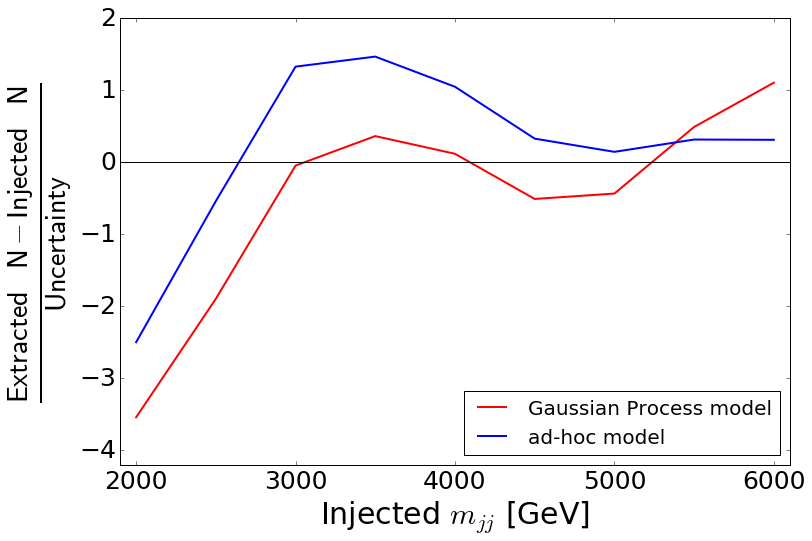

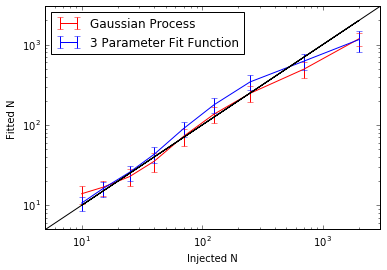

In [21]:
if runOnlyGP or runOnlyFF: pass
else:
    Nsignals = [standardParamSets[i][0] for i in range(len(standardParamSets))]
    msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
    muGP=[]
    muSTD=[]
    for mi, m in enumerate(msignals):
        muGP_p = np.load("newoutputs/LLHR_GP_N_"+str(m)+".npy")
        muSTD_p = np.load("newoutputs/LLHR_FF_N_"+str(m)+".npy")
        muGP.append((np.mean(muGP_p*standardParamSets[mi][0]), np.std(muGP_p*standardParamSets[mi][0])))
        muSTD.append((np.mean(muSTD_p), np.std(muSTD_p)))
     
    print muGP_p*standardParamSets[-1][0], muSTD_p
    print muGP[-1][0], muSTD[-1][0]
    
    print (muGP[-1][0]-standardParamSets[-1][0])/standardParamSets[-1][0]
    print (muSTD[-1][0]-standardParamSets[-1][0])/standardParamSets[-1][0]
    print (muGP[-1][0]-Nsignals[-1])/Nsignals[-1]
    print (muSTD[-1][0]-Nsignals[-1])/Nsignals[-1]

    
    print (np.array([muSTD[i][0] for i in range(len(Nsignals))])-np.array(Nsignals))/np.array(Nsignals)
    print (np.array([muGP[i][0] for i in range(len(Nsignals))])-np.array(Nsignals))/np.array(Nsignals)
    
    f, ax1 = plt.subplots(1, figsize=(12,8))
    ax1.plot(msignals, (np.array([muGP[i][0] for i in range(len(Nsignals))])-np.array(Nsignals))/np.array([muGP[i][1] for i in range(len(Nsignals))]), color="r", lw=2,label="Gaussian Process")
    ax1.plot(msignals, (np.array([muSTD[i][0] for i in range(len(Nsignals))])-np.array(Nsignals))/np.array([muSTD[i][1] for i in range(len(Nsignals))]), color="b", lw=2, label="ad-hoc function")
    #ax1.errorbar(msignals, np.abs(np.array([muGP[i][0] for i in range(len(Nsignals))])-np.array(Nsignals)), yerr = np.array([muGP[i][1] for i in range(len(Nsignals))]), color="r", lw=2,label="Gaussian Process model")
    #ax1.errorbar(msignals, np.abs(np.array([muSTD[i][0] for i in range(len(Nsignals))])-np.array(Nsignals)),  yerr = np.array([muSTD[i][1] for i in range(len(Nsignals))]), color="b", lw=2, label="ad-hoc model")
    ax1.plot([1500]+msignals+[6500], np.zeros(len(msignals)+2), ls='-', color='black')


    ax1.set_xlabel(r"Injected $m_{jj}$ [GeV]", fontsize=30)
    ax1.set_ylabel(r'$\mathrm{\mathsf{\frac{Extracted\quadN - Injected\quadN}{Uncertainty}}}$', fontsize=40)
    #ax1.set_ylabel('Extracted N - Injected N', fontsize=30)
    ax1.legend(loc=4, prop={'size':20})
    ax1.tick_params(axis='y', labelsize=25)
    ax1.tick_params(axis='x', labelsize=25)
    
    #ax1.set_yscale('log', nonposy="clip")
    ax1.set_xlim([1900,6100])
    ax1.set_ylim([-4.2,2])

    ####################
    #Nsignals = [standardParamSets[i][0] for i in range(len(standardParamSets))]
    plt.figure()
    plt.errorbar(Nsignals, [muGP[i][0] for i in range(len(Nsignals))], yerr = [muGP[i][1] for i in range(len(Nsignals))], color="r", label="Gaussian Process")
    plt.errorbar(Nsignals, [muSTD[i][0] for i in range(len(Nsignals))], yerr = [muSTD[i][1] for i in range(len(Nsignals))], color="b", label="3 Parameter Fit Function")
    plt.plot([0]+Nsignals+[1e4], [0]+Nsignals+[1e4], c="black")

    plt.xlabel("Injected N")
    plt.yscale('log', nonposy="clip")
    plt.xscale('log', nonposy="clip")
    plt.ylabel("Fitted N")
    plt.legend(loc=2)
    plt.ylim([5, 3e3])
    plt.xlim([5, 3e3])

    
    


### For when looking at various likelihood calculations

if runOnlyGP or runOnlyFF: pass
else:
    plt.figure()
    plt.errorbar(msignals, [np.median(np.array(LLlistGP[m])-np.array(LLlistGPG[m])) for m in msignals], yerr = [np.std(np.array(LLlistGP[m])-np.array(LLlistGPG[m])) for m in msignals], color="b")

    plt.xlabel("signal MASS [GeV]")
    plt.xlim([1900, 6100])
    plt.title("Constraint term")
    plt.ylabel("Constraint term")
    plt.legend(loc=1)
    
    for m in msignals:
        plt.figure()
        plt.hist(np.array(LLlistGP[m])-np.array(LLlistGPG[m]), bins=np.linspace(min(np.array(LLlistGP[m])-np.array(LLlistGPG[m])), max(np.array(LLlistGP[m])-np.array(LLlistGPG[m])), 50))
        plt.title("Distribution of contraint term for mass = "+str(m))

if runOnlyGP or runOnlyFF: pass
else:
    for m in msignals:
        ff = [s for s in LLlistFF_2[m] if not (np.isinf(s) or np.isnan(s))]
        ffng = [s for s in LLlistFFng_2[m] if not (np.isinf(s) or np.isnan(s))]
        ffG = [s for s in LLlistFFG_2[m] if not (np.isinf(s) or np.isnan(s))]
        gp = [s for s in LLlistGP[m] if not (np.isinf(s) or np.isnan(s))]
        gpP = [s for s in LLlistGPP[m] if not (np.isinf(s) or np.isnan(s))]
        gpng = [s for s in LLlistGPng[m] if not (np.isinf(s) or np.isnan(s))]
        gpG = [s for s in LLlistGPG[m] if not (np.isinf(s) or np.isnan(s))]
        
        smallest = min(len(ff),len(gp), len(ffng), len(ffG))
        print smallest
        LLH_values=np.empty((smallest, 7))
        print LLH_values.shape
        LLH_values[:,0]=gpP[:smallest]
        LLH_values[:,1]=gpng[:smallest]
        LLH_values[:,2]=gpG[:smallest]
        LLH_values[:,3]=gp[:smallest]
        LLH_values[:,4]=ff[:smallest]
        LLH_values[:,5]=ffng[:smallest]
        LLH_values[:,6]=ffG[:smallest]
        labels = ["GP Poissson", "GP Poisson no lngamma", "GP Gaussian", "GP george", "FF Poisson", "FF Poisson no lngamma", "FF Gaussian"]
    fig = corner.corner(LLH_values, labels=labels)